<a href="https://colab.research.google.com/github/Zhang-Cheng-76200/Random-Walk-Prediction/blob/main/random_walk_prediction_sp500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rule-based Fusion for Random Walk Time Series Forecasting

exp1

Achieve accurate point forecasting through the fusion of binary classification and naive forecasting.

In [1]:
import keras.backend as K
import tensorflow as tf

import keras
from keras import backend as K
from keras import initializers, layers, models, optimizers, callbacks, utils
from keras.models import load_model
from keras.models import model_from_json

from keras.initializers import glorot_uniform

from keras.initializers import *
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.utils import *

from keras import losses
from tensorflow.python.platform import tf_logging as logging

import os
import copy
import pickle
import pandas as pd
import math
import scipy
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller

In [3]:
import statsmodels.api as sm
from sklearn.datasets import make_classification
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
from sklearn.svm import SVC
from sklearn.svm import NuSVC
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.utils import resample

In [6]:
from sklearn.linear_model import LogisticRegression

In [7]:
import random

In [8]:
from sklearn.model_selection import StratifiedKFold

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE

In [10]:
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2

In [11]:
pip install pmdarima

In [12]:
# Set seed
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

## Raw data

A couple of things to note:

- There is no need to save the data points as numpy arrays, regular lists is fine.
- The `time` list should contain every timestep (starting at zero), which is just a sequence of ordered numbers with the same length as the `series` list.
- The values of the `series` should be of `float` type. You can use Python's built-in `float` function to ensure this.

Begin by looking at the structure of the xlsx file that contains the data:

In [13]:
from google.colab import drive
drive.mount ('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [14]:
SP500_raw = pd.read_excel('/content/gdrive/MyDrive/Random_walk_prediction/SP500.xlsx')

In [15]:
SP500_raw

,Date,Open,High,Low,Close,Volume
0,2010-04-01 00:00:00,1116.56,1133.87,1116.56,1132.99,3991400000
1,2010-05-01 00:00:00,1132.66,1136.63,1129.66,1136.52,2491020000
2,2010-06-01 00:00:00,1135.71,1139.19,1133.95,1137.14,4972660000
3,2010-07-01 00:00:00,1136.27,1142.46,1131.32,1141.69,5270680000
4,2010-08-01 00:00:00,1140.52,1145.39,1136.22,1144.98,4389590000
...,...,...,...,...,...,...
2511,12/24/19,3225.45,3226.43,3220.51,3223.38,1296530000
2512,12/26/19,3227.20,3240.08,3227.20,3239.91,2164540000
2513,12/27/19,3247.23,3247.93,3234.37,3240.02,2429150000
2514,12/30/19,3240.09,3240.92,3216.57,3221.29,3021720000


In [16]:
series = SP500_raw.iloc[:,4] # close price
time = []
for i in range(0, len(series)):
  time.append(i)

In [17]:
# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME = np.array(time)
    SERIES = np.array(series)
    SPLIT_TIME = 200          # data splitting, 200 samples are thevalidation set and 100 samples are the test set.
    WINDOW_SIZE = 50          # sequence length
    BATCH_SIZE = 32           # batch size

In [18]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

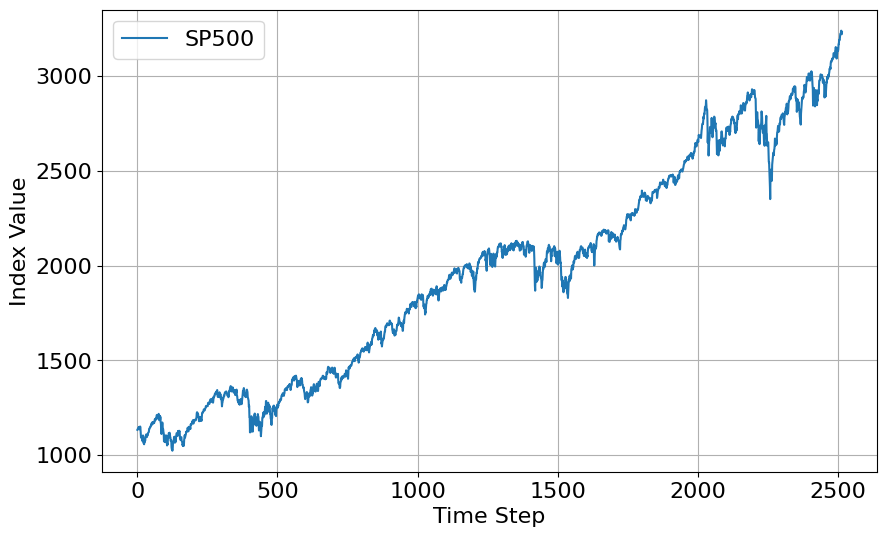

In [19]:
plt.rcParams['font.size'] = '16'
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["SP500"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Random_walk_prediction/figures/SP500_original.svg")
plt.show()

## Random Walk and Autocorrelation

We can calculate the correlation between each observation and the observations at previous time steps. A plot of these correlations is called an autocorrelation plot or a correlogram.

Given the way that the random walk is constructed, we would expect a strong autocorrelation with the previous observation and a linear fall off from there with previous lag values.

We can use the autocorrelation_plot() function in Pandas to plot the correlogram for the random walk.

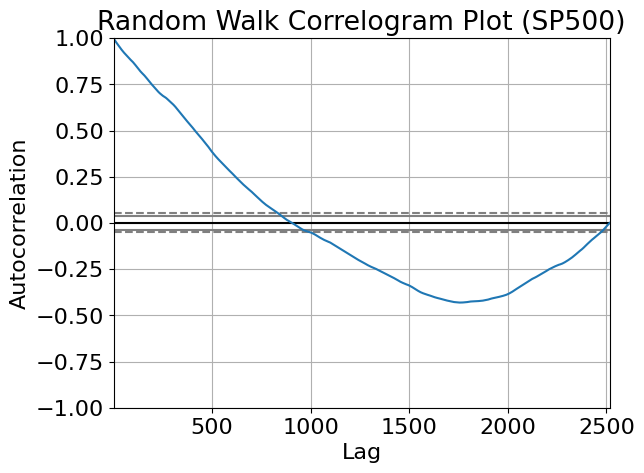

<Figure size 640x480 with 0 Axes>

In [20]:
autocorrelation_plot(G.SERIES)
plt.title("Random Walk Correlogram Plot (SP500)")
plt.show()
plt.savefig("/content/gdrive/MyDrive/Random_walk_prediction/figures/SP500_correlation.svg")

## Random Walk and Stationarity

We can confirm this using a statistical significance test, specifically the Augmented Dickey-Fuller test.

We can perform this test using the adfuller() function in the statsmodels library. The complete example is listed below.

In [21]:
# statistical test
result = adfuller(G.SERIES)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.416927
p-value: 0.982117
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


The null hypothesis of the test is that the time series is non-stationary.

Running the example, we can see that the test statistic value was  -1.952841. This is larger than all of the critical values at the 1%, 5%, and 10% confidence levels. Therefore, we can say that the time series does appear to be non-stationary with a low likelihood of the result being a statistical fluke.

## Pre-defined funcitons

In [22]:
def min_max_normalization(series):
  series = (series - min(series_train))/(max(series_train) - min(series_train))
  return series

In [23]:
def Wilder(data, periods):
    start = np.where(~np.isnan(data))[0][0] #Check if nans present in beginning
    Wilder = np.array([np.nan]*len(data))
    Wilder[start+periods-1] = data[start:(start+periods)].mean() #Simple Moving Average
    for i in range(start+periods,len(data)):
        Wilder[i] = (Wilder[i-1]*(periods-1) + data[i])/periods #Wilder Smoothing
    return(Wilder)

In [24]:
def train_test_split_classification(features, labels, time_step=G.SPLIT_TIME):

    X_train = features[:-G.SPLIT_TIME]
    y_train = labels[:-G.SPLIT_TIME]
    X_test = features[-G.SPLIT_TIME:]
    y_test = labels[-G.SPLIT_TIME:]

    return X_train, y_train, X_test, y_test

In [25]:
def train_test_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:-G.SPLIT_TIME]
    series_train = series[:-G.SPLIT_TIME]
    time_test = time[-G.SPLIT_TIME:]
    series_test = series[-G.SPLIT_TIME:]

    return time_train, series_train, time_test, series_test

In [26]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [27]:
def reverse_normalization(series):
  series = series * (max(series_train) - min(series_train)) + min(series_train)
  return series

In [28]:
def eliminate_adjacent(data):
    # Copy the list to avoid modifying the original list
    new_data = data.copy()
    n = len(data)

    for i in range(n):
        # Check if the current element is 1 or 0
        if data[i] in [1, 0]:
            # Check previous and next elements, considering edge cases
            prev_val = data[i-1] if i > 0 else None
            next_val = data[i+1] if i < n-1 else None

            # If the current element is not isolated (i.e., has same value neighbors), change it to 'nan'
            if data[i] == prev_val or data[i] == next_val:
                new_data[i] = 'nan'

    return new_data

In [29]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    rmse = tf.math.sqrt(mse).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    mape = tf.keras.metrics.mean_absolute_percentage_error(true_series, forecast).numpy()
    return rmse, mae, mape

In [30]:
# Define PICP (PI coverage probability)

def PICP(upper_bound, lower_bound, real_value):
  c = np.array(0)
  for i in range(len(real_value)):
    if ((real_value[i] <= upper_bound[i]) & (real_value[i] >= lower_bound[i])):
      c = c+1
  picp = c / len(real_value)
  return picp

In [31]:
# Define NMPIW (Normalized Mean PI width)

def NMPIW(upper_bound, lower_bound, real_value):
   return tf.reduce_mean(upper_bound - lower_bound) / (np.max(real_value)-np.min(real_value))

## Data preprocessing

In [32]:
# Split the dataset
time_train, series_train, time_test, series_test = train_test_split(G.TIME, G.SERIES)
series_norm = min_max_normalization(G.SERIES)
series_train_norm = series_norm[:-G.SPLIT_TIME]
series_test_norm = series_norm[-G.SPLIT_TIME:]

## Rule-based movement prediction sifting

### Feature engineering

In [33]:
SP500_raw['Date'] = pd.to_datetime(SP500_raw['Date'])
SP500_raw['Date'] = SP500_raw['Date'].dt.strftime('%Y-%m-%d')
series = SP500_raw.iloc[:,4] # close price
time = []
for i in range(0, len(series)):
  time.append(i)

TIME = np.array(time)
SERIES = np.array(series)

SP500_raw['return'] = SP500_raw['Close'].pct_change()
SP500_raw['SMA_5'] = SP500_raw['Close'].transform(lambda x: x.rolling(window = 5).mean())
SP500_raw['SMA_15'] = SP500_raw['Close'].transform(lambda x: x.rolling(window = 15).mean())
SP500_raw['SMA_ratio'] = SP500_raw['SMA_15'] / SP500_raw['SMA_5']
SP500_raw['SMA5_Volume'] = SP500_raw['Volume'].transform(lambda x: x.rolling(window = 5).mean())
SP500_raw['SMA15_Volume'] = SP500_raw['Volume'].transform(lambda x: x.rolling(window = 15).mean())
SP500_raw['SMA_Volume_Ratio'] = SP500_raw['SMA5_Volume']/SP500_raw['SMA15_Volume']
SP500_raw['prev_close'] = SP500_raw['Close'].shift(1)
SP500_raw['TR'] = np.maximum((SP500_raw['High'] - SP500_raw['Low']),
                    np.maximum(abs(SP500_raw['High'] - SP500_raw['prev_close']),
                    abs(SP500_raw['prev_close'] - SP500_raw['Low'])))
SP500_raw['Lowest_5D'] = SP500_raw['Low'].transform(lambda x: x.rolling(window = 5).min())
SP500_raw['High_5D'] = SP500_raw['High'].transform(lambda x: x.rolling(window = 5).max())
SP500_raw['Lowest_15D'] = SP500_raw['Low'].transform(lambda x: x.rolling(window = 15).min())
SP500_raw['High_15D'] = SP500_raw['High'].transform(lambda x: x.rolling(window = 15).max())
SP500_raw['Stochastic_5'] = ((SP500_raw['Close'] - SP500_raw['Lowest_5D'])/(SP500_raw['High_5D'] - SP500_raw['Lowest_5D']))*100
SP500_raw['Stochastic_15'] = ((SP500_raw['Close'] - SP500_raw['Lowest_15D'])/(SP500_raw['High_15D'] - SP500_raw['Lowest_15D']))*100
SP500_raw['Stochastic_%D_5'] = SP500_raw['Stochastic_5'].rolling(window = 5).mean()
SP500_raw['Stochastic_%D_15'] = SP500_raw['Stochastic_5'].rolling(window = 15).mean()
SP500_raw['Stochastic_Ratio'] = SP500_raw['Stochastic_%D_5']/SP500_raw['Stochastic_%D_15']
SP500_raw['Diff'] = SP500_raw['Close'].transform(lambda x: x.diff())
SP500_raw['Up'] = SP500_raw['Diff']
SP500_raw.loc[(SP500_raw['Up']<0), 'Up'] = 0
SP500_raw['Down'] = SP500_raw['Diff']
SP500_raw.loc[(SP500_raw['Down']>0), 'Down'] = 0
SP500_raw['Down'] = abs(SP500_raw['Down'])
SP500_raw['avg_5up'] = SP500_raw['Up'].transform(lambda x: x.rolling(window=5).mean())
SP500_raw['avg_5down'] = SP500_raw['Down'].transform(lambda x: x.rolling(window=5).mean())
SP500_raw['avg_15up'] = SP500_raw['Up'].transform(lambda x: x.rolling(window=15).mean())
SP500_raw['avg_15down'] = SP500_raw['Down'].transform(lambda x: x.rolling(window=15).mean())
SP500_raw['RS_5'] = SP500_raw['avg_5up'] / SP500_raw['avg_5down']
SP500_raw['RS_15'] = SP500_raw['avg_15up'] / SP500_raw['avg_15down']
SP500_raw['RSI_5'] = 100 - (100/(1+SP500_raw['RS_5']))
SP500_raw['RSI_15'] = 100 - (100/(1+SP500_raw['RS_15']))
SP500_raw['RSI_ratio'] = SP500_raw['RSI_5']/SP500_raw['RSI_15']
SP500_raw['5Ewm'] = SP500_raw['Close'].transform(lambda x: x.ewm(span=5, adjust=False).mean())
SP500_raw['15Ewm'] = SP500_raw['Close'].transform(lambda x: x.ewm(span=15, adjust=False).mean())
SP500_raw['MACD'] = SP500_raw['15Ewm'] - SP500_raw['5Ewm']
SP500_raw['15MA'] = SP500_raw['Close'].transform(lambda x: x.rolling(window=15).mean())
SP500_raw['SD'] = SP500_raw['Close'].transform(lambda x: x.rolling(window=15).std())
SP500_raw['upperband'] = SP500_raw['15MA'] + 2*SP500_raw['SD']
SP500_raw['lowerband'] = SP500_raw['15MA'] - 2*SP500_raw['SD']
SP500_raw['RC'] = SP500_raw['Close'].transform(lambda x: x.pct_change(periods = 15))
SP500_raw['label'] = 1

In [34]:
# Use .loc to set 'label' values conditionally
SP500_raw.loc[SP500_raw['return'] > 0, 'label'] = 1
SP500_raw.loc[SP500_raw['return'] <= 0, 'label'] = 0

In [35]:
SP500_raw = SP500_raw[100:]
SP500_raw = SP500_raw.iloc[:, 1:47]
SP500_raw = SP500_raw.drop('RS_5', axis=1)

In [36]:
SP500_new = SP500_raw
feature_table = SP500_new.iloc[:-1, 0:42]
labels = SP500_new['label']
labels = labels[1:]
labels = list(labels)
labels = pd.DataFrame(labels, columns=['Label'])

X_train, y_train, X_test, y_test = train_test_split_classification(feature_table, labels)

scaler = MinMaxScaler()
X_train_minmax = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_minmax = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
X_train = X_train_minmax.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test_minmax.to_numpy()
y_test = y_test.to_numpy()
y_train = y_train.ravel()
y_test = y_test.ravel()

print(SP500_new.shape, feature_table.shape, X_train.shape, X_test.shape)

(2416, 43) (2415, 42) (2215, 42) (200, 42)


In [37]:
# Assuming X_train, y_train are already defined
# Divide X_test, y_test into two parts: validation and test
X_val, y_val = X_test[:100], y_test[:100]
X_test_final, y_test_final = X_test[100:200], y_test[100:200]

### Model training and prediction sifting

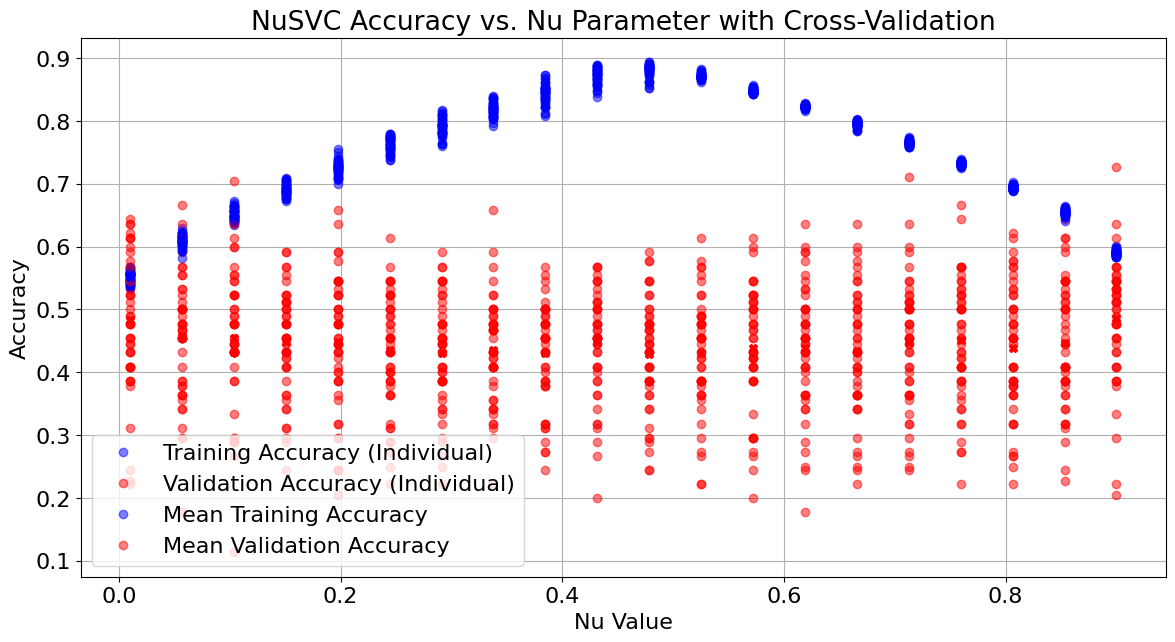

In [38]:
# Assuming X_train, y_train, X_test, y_test are predefined and properly preprocessed
current_train_set = np.copy(X_train)
current_labels_set = np.copy(y_train)
current_test_set = np.copy(X_test)
current_test_labels = np.copy(y_test)

# List of nu values to try
nu_values = np.linspace(0.01, 0.9, 20)
k_folds = 50  # Number of folds
kf = StratifiedKFold(n_splits=k_folds)

# Prepare to collect accuracies and store models for each fold
fold_train_accuracies = {nu: [] for nu in nu_values}
fold_test_accuracies = {nu: [] for nu in nu_values}
models = {nu: [] for nu in nu_values}  # Dictionary to store models

# Perform cross-validation
for train_index, val_index in kf.split(current_train_set, current_labels_set):
    X_train_fold, X_val_fold = current_train_set[train_index], current_train_set[val_index]
    y_train_fold, y_val_fold = current_labels_set[train_index], current_labels_set[val_index]

    for nu in nu_values:
        # Initialize the NuSVC classifier with different nu
        nu_svc_model = NuSVC(nu=nu, kernel='rbf', gamma='scale')
        # Train the NuSVC model on the training part of the fold
        nu_svc_model.fit(X_train_fold, y_train_fold)
        # Store the trained model
        models[nu].append(nu_svc_model)
        # Predict and calculate accuracy on the training part
        train_predictions = nu_svc_model.predict(X_train_fold)
        train_accuracy = accuracy_score(y_train_fold, train_predictions)
        fold_train_accuracies[nu].append(train_accuracy)
        # Predict and calculate accuracy on the validation part
        val_predictions = nu_svc_model.predict(X_val_fold)
        val_accuracy = accuracy_score(y_val_fold, val_predictions)
        fold_test_accuracies[nu].append(val_accuracy)

# Plotting the results
plt.figure(figsize=(14, 7))
for nu in nu_values:
    train_accuracies = fold_train_accuracies[nu]
    test_accuracies = fold_test_accuracies[nu]
    for i in range(k_folds):
        plt.plot(nu, train_accuracies[i], 'bo', alpha=0.5)
        plt.plot(nu, test_accuracies[i], 'ro', alpha=0.5)
    plt.plot(nu, np.mean(train_accuracies), 'bX')
    plt.plot(nu, np.mean(test_accuracies), 'rX')

plt.title('NuSVC Accuracy vs. Nu Parameter with Cross-Validation')
plt.xlabel('Nu Value')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy (Individual)', 'Validation Accuracy (Individual)',
            'Mean Training Accuracy', 'Mean Validation Accuracy'], loc='best')
plt.grid(True)
plt.show()





In [39]:
# Rank Nu values by mean validation accuracy and select the best
mean_valid_acc = {nu: np.mean(fold_test_accuracies[nu]) for nu in nu_values}
best_nu = min(mean_valid_acc, key=mean_valid_acc.get)

In [40]:
mean_valid_acc

{0.01: 0.4836060606060606,
 0.056842105263157895: 0.45825252525252524,
 0.10368421052631578: 0.4543030303030302,
 0.15052631578947367: 0.44891919191919194,
 0.19736842105263158: 0.44810101010101017,
 0.2442105263157895: 0.435030303030303,
 0.29105263157894734: 0.4308888888888889,
 0.33789473684210525: 0.43494949494949503,
 0.38473684210526315: 0.4312828282828283,
 0.43157894736842106: 0.4475454545454545,
 0.47842105263157897: 0.42939393939393944,
 0.5252631578947369: 0.43123232323232324,
 0.5721052631578947: 0.4385050505050505,
 0.6189473684210526: 0.43839393939393945,
 0.6657894736842105: 0.43386868686868696,
 0.7126315789473684: 0.44779797979797975,
 0.7594736842105263: 0.4509292929292929,
 0.8063157894736842: 0.43832323232323234,
 0.8531578947368421: 0.44735353535353534,
 0.9: 0.48674747474747476}

In [41]:
# Use the stored models with the best nu to make predictions on the test set
predictions = []
for model in models[best_nu]:
    predictions.append(model.predict(current_test_set))

# Use majority voting method for final prediction, accepting when votes > 25
prediction_array = np.array(predictions)

In [42]:
final_predictions = np.full(current_test_labels.shape, np.nan)  # Initialize with NaN
for i in range(prediction_array.shape[1]):
    votes = np.bincount(prediction_array[:, i])
    max_votes = np.max(votes)
    if max_votes >=50:  # Change the threshold to > 25
        final_predictions[i] = np.argmax(votes)

# Calculate final accuracy for non-NaN predictions
valid_indices = ~np.isnan(final_predictions)
valid_predictions = final_predictions[valid_indices]
valid_true_labels = current_test_labels[valid_indices]
final_accuracy = accuracy_score(valid_true_labels, valid_predictions) if valid_predictions.size > 0 else None
print("Final Accuracy with majority voting:", final_accuracy)

Final Accuracy with majority voting: 0.41353383458646614


In [43]:
final_predictions = 1 - final_predictions

In [44]:
final_predictions

array([ 1., nan,  1., nan,  1.,  1.,  1.,  1., nan, nan,  1., nan,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1., nan, nan, nan,  1., nan, nan,
       nan, nan, nan, nan, nan, nan,  1.,  1.,  1., nan,  1.,  1., nan,
        1.,  1.,  1.,  1., nan, nan,  1.,  1., nan, nan,  1., nan, nan,
        1., nan, nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., nan, nan,  1.,  1., nan,  1., nan,  1.,
        1.,  1.,  1.,  1.,  1.,  1., nan,  1., nan, nan,  0., nan, nan,
        1.,  1.,  1., nan, nan, nan, nan,  1.,  1.,  1., nan,  1.,  1.,
       nan, nan,  1.,  1., nan, nan, nan,  0.,  1.,  1.,  1.,  1., nan,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1., nan,  1.,  1.,  1.,  1., nan,  1., nan, nan,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       nan, nan, nan, nan,  1.,  1.,  1., nan, nan, nan, nan, na

In [1103]:
np.savetxt("/content/gdrive/MyDrive/Random_walk_prediction/files/test_set_label_SP500.csv",
           y_test_final, delimiter=",", fmt='%s')

np.savetxt("/content/gdrive/MyDrive/Random_walk_prediction/files/all_movement_predictions_SP500_exp1.csv",
           reverse_final_predictions, delimiter=",", fmt='%s')

## Fusion of binary classification and naive forecasting

### Naive forecasting


In [45]:
# Define alpha
alpha = 0.025

In [46]:
series_y_hat_naive = G.SERIES[G.WINDOW_SIZE-1:-1]

# error series

abs_error_naive = np.abs(G.SERIES[G.WINDOW_SIZE:]-series_y_hat_naive)
series_test_hat_naive = series_y_hat_naive[-G.SPLIT_TIME:]
series_test_hat_naive_up = []
series_test_hat_naive_low = []

for i in range(len(series_test)):
  error = np.sort(abs_error_naive[i:i-len(series_test)], kind='quicksort')[::-1] ## this line of code is taking a slice from the abs_error_naive array,
                                                                                 ## sorting it in ascending order using the QuickSort algorithm,
                                                                                 ## and then reversing it to get the array in descending order.
                                                                                 ## The result is stored in the variable error.
  up_bound = np.quantile(error, [1-alpha])
  low_bound = -np.quantile(error, [1-alpha])
  series_test_hat_naive_up.append(series_test_hat_naive[i] + up_bound)
  series_test_hat_naive_low.append(series_test_hat_naive[i] + low_bound)

series_test_hat_naive_up = np.array(series_test_hat_naive_up)
series_test_hat_naive_low = np.array(series_test_hat_naive_low)

series_test_hat_naive_up = np.squeeze(series_test_hat_naive_up)
series_test_hat_naive_low = np.squeeze(series_test_hat_naive_low)

bound_width_naive = series_test_hat_naive_up-series_test_hat_naive_low

PICP_naive = PICP(series_test_hat_naive_up, series_test_hat_naive_low, series_test)

NMPIW_naive = NMPIW(series_test_hat_naive_up, series_test_hat_naive_low, series_test)

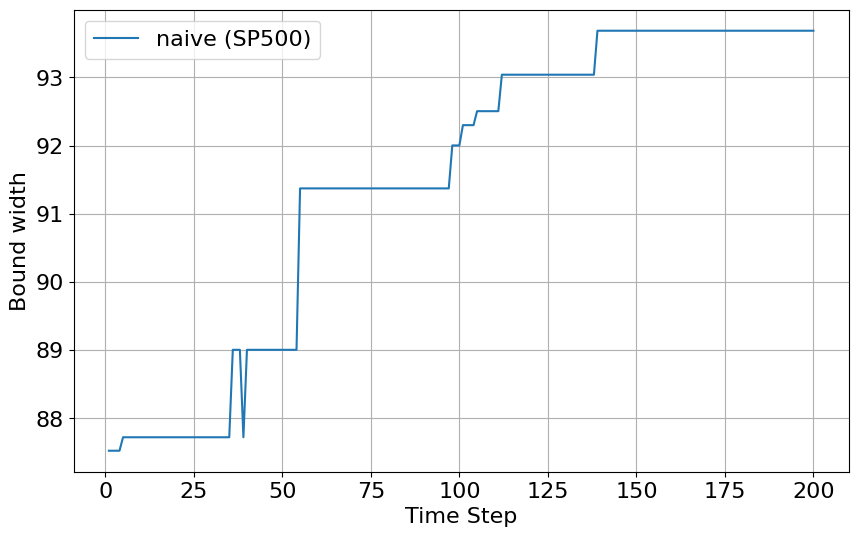

In [47]:
plt.figure(figsize=(10, 6))
plot_series(np.arange( 1, len(time_test)+1 ), bound_width_naive)
plt.ylabel("Bound width")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["naive (SP500)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Random_walk_prediction/figures/naive_forecasts_bound_width_SP500.svg")

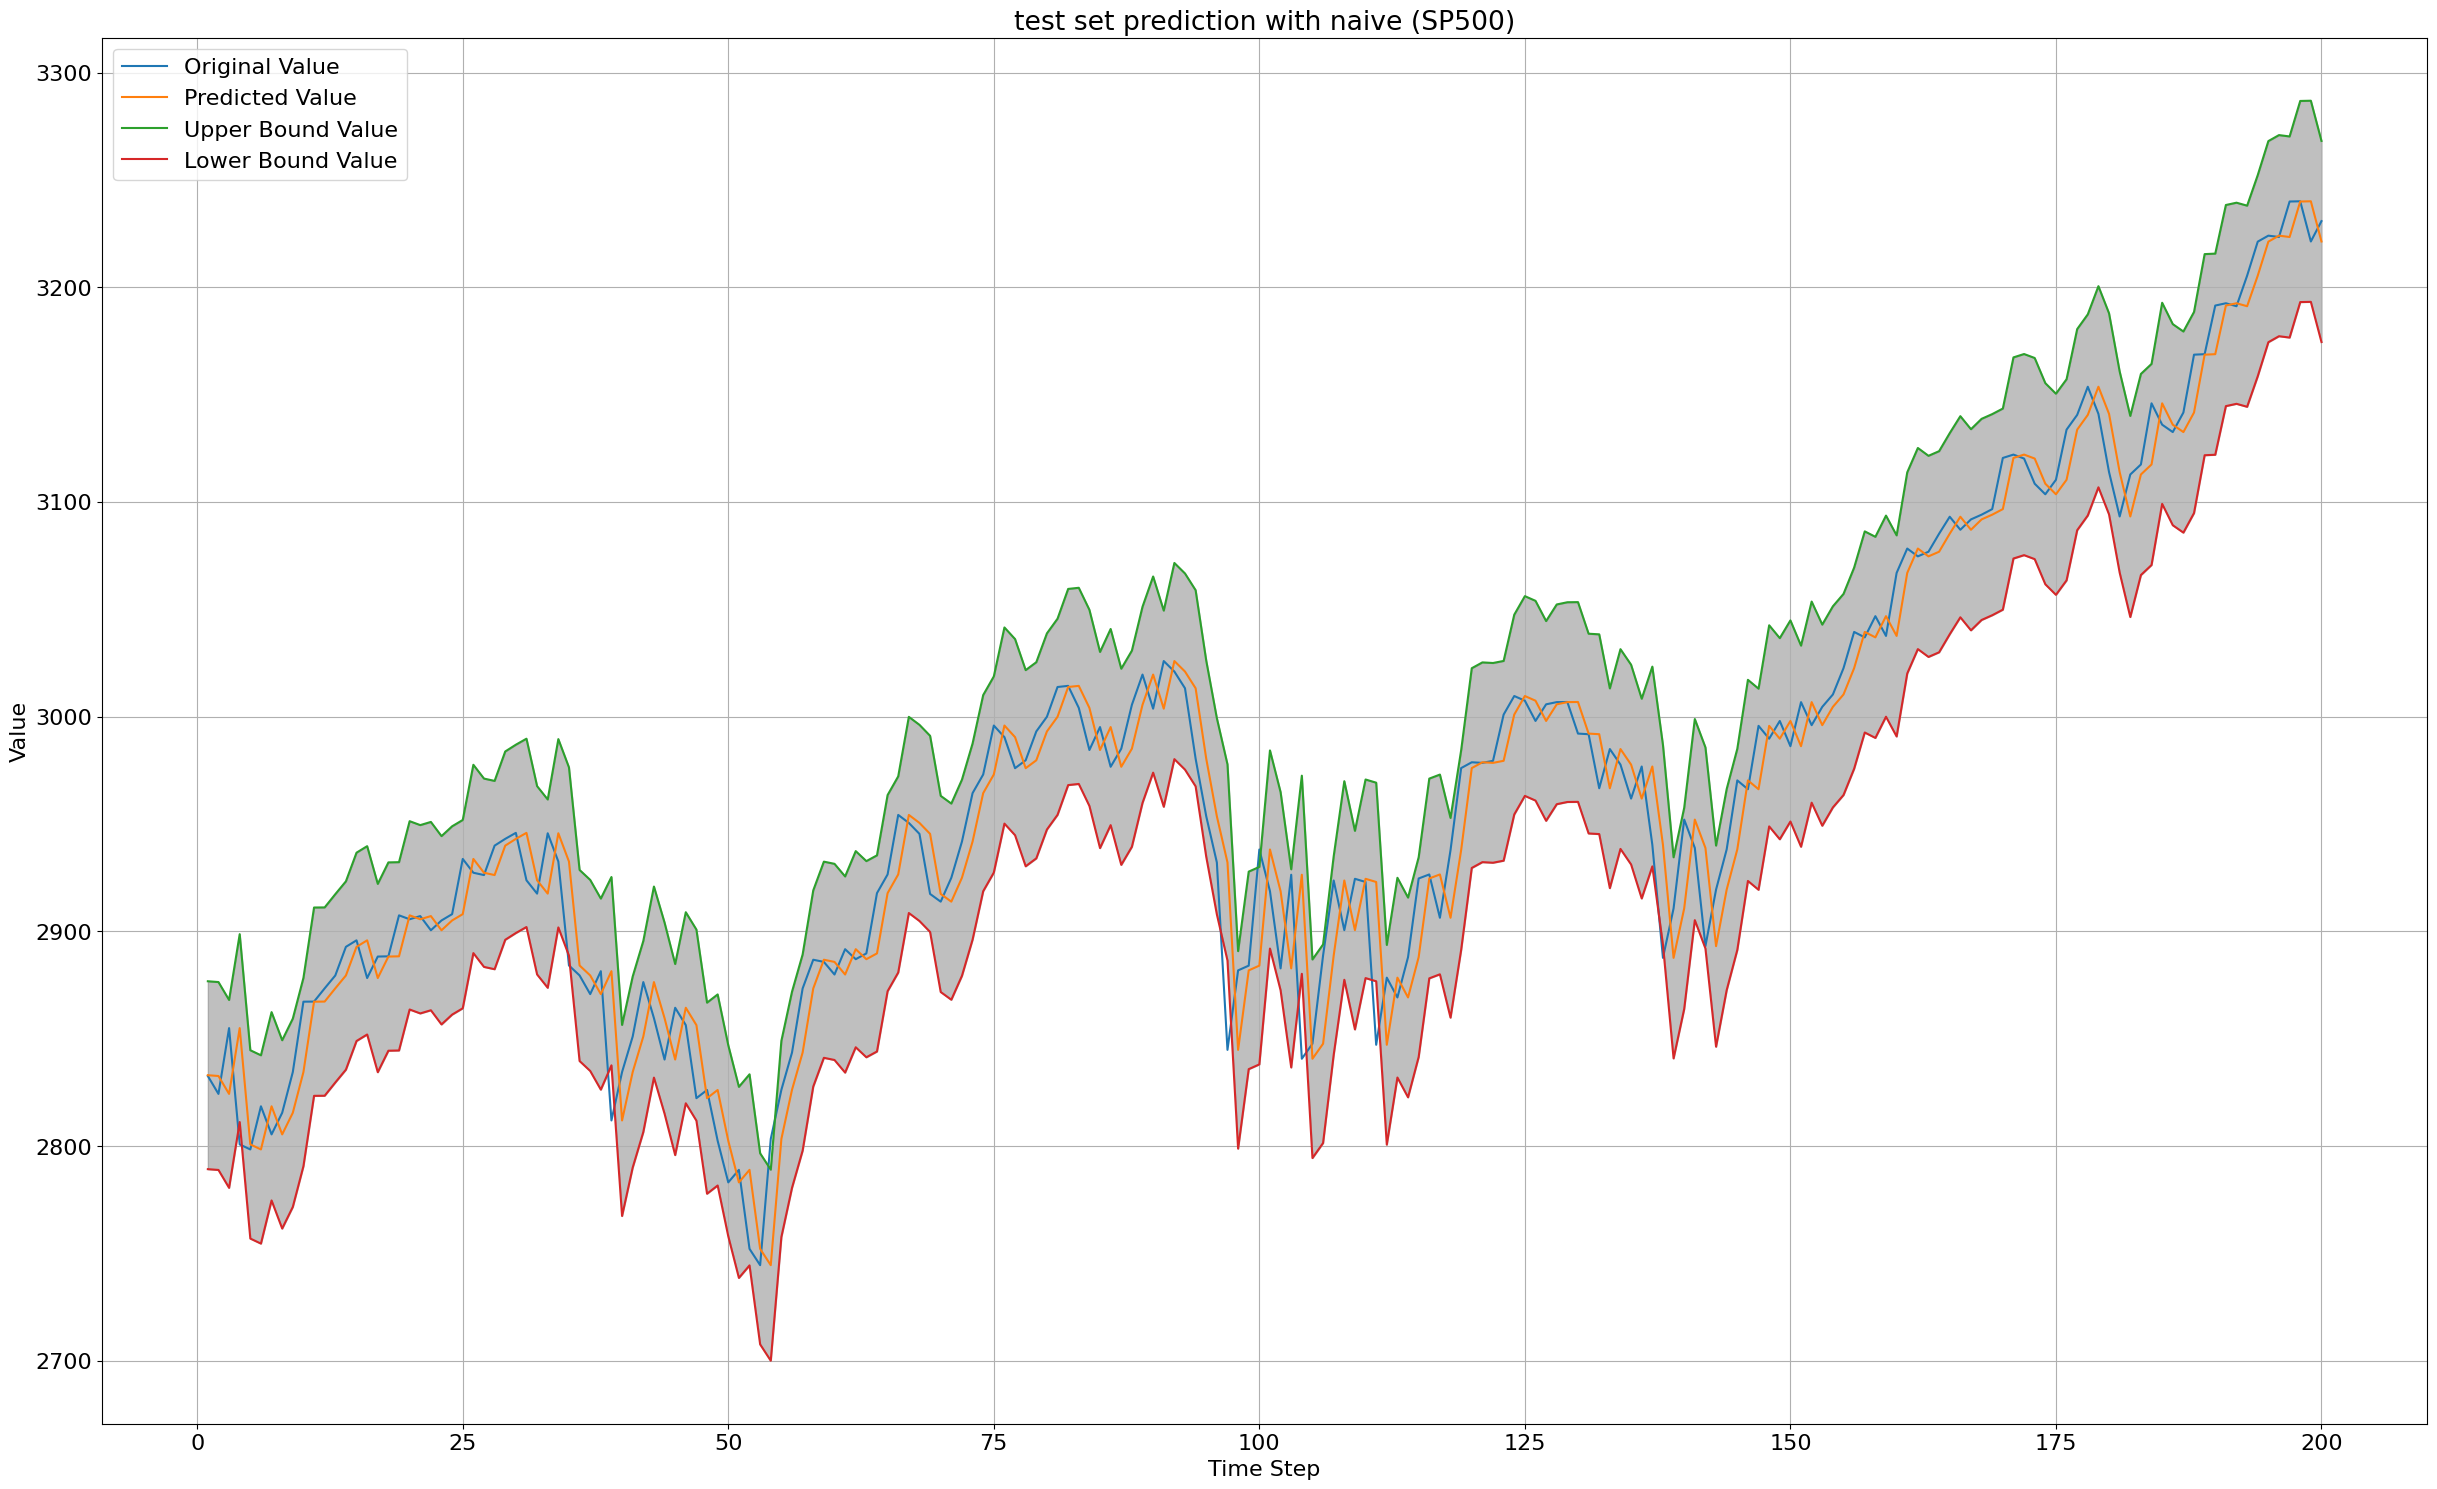

In [48]:
# Plot the forecast

plt.figure(figsize=(30, 18))
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_naive)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_naive_up)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_naive_low)
plt.fill_between(np.arange( 1, len(time_test)+1 ), series_test_hat_naive_up, series_test_hat_naive_low, color='gray', alpha=0.5)
plt.ylabel("Value")
plt.xlabel("Time Step")
plt.title("test set prediction with naive (SP500)")
legend_drawn_flag = True
plt.legend(["Original Value", "Predicted Value", "Upper Bound Value", "Lower Bound Value"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Random_walk_prediction/figures/naive_forecasts_bounds_SP500.svg")

In [1305]:
# Save predicted values

np.savetxt("/content/gdrive/MyDrive/Random_walk_prediction/files/naive_predicted_mean_SP500.csv",
           series_test_hat_naive.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/Random_walk_prediction/files/naive_predicted_up_SP500.csv",
           series_test_hat_naive_up.T, delimiter=",")

np.savetxt("/content/gdrive/MyDrive/Random_walk_prediction/files/naive_predicted_low_SP500.csv",
           series_test_hat_naive_low.T, delimiter=",")

### Fusion results

In [49]:
z_score = 1.96

In [50]:
standard_deviation_naive = []
for j in range(len(bound_width_naive)):
  standard_deviation_naive.append(bound_width_naive[j] / (2 * z_score))

In [51]:
###################################################################################################
series_test_hat_naive_calibrated = series_test_hat_naive.copy()

for m in range(200):
  if final_predictions[m] == 1:
    series_test_hat_naive_calibrated[m] = series_test_hat_naive[m] + 0.15 * standard_deviation_naive[m]
  if final_predictions[m] == 0:
    series_test_hat_naive_calibrated[m] = series_test_hat_naive[m] - 0.15  *  standard_deviation_naive[m]
###################################################################################################

rmse_test_fusion, mae_test_fusion, mape_test_fusion= compute_metrics(series_test, series_test_hat_naive_calibrated)


In [52]:
rmse_naive_test, mae_naive_test, mape_naive_test= compute_metrics(series_test, series_test_hat_naive)

In [53]:
print(f"rmse_test: {rmse_test_fusion:.4f}, mae_test: {mae_test_fusion:.4f} , mape_test: {mape_test_fusion:.4f}")

rmse_test: 22.2277, mae_test: 16.2096 , mape_test: 0.5528


In [54]:
print(f"rmse_naive_test: {rmse_naive_test:.4f}, mae_naive_test: {mae_naive_test:.4f} , mape_naive_test: {mape_naive_test:.4f} for forecast")

rmse_naive_test: 22.3468, mae_naive_test: 16.2771 , mape_naive_test: 0.5548 for forecast


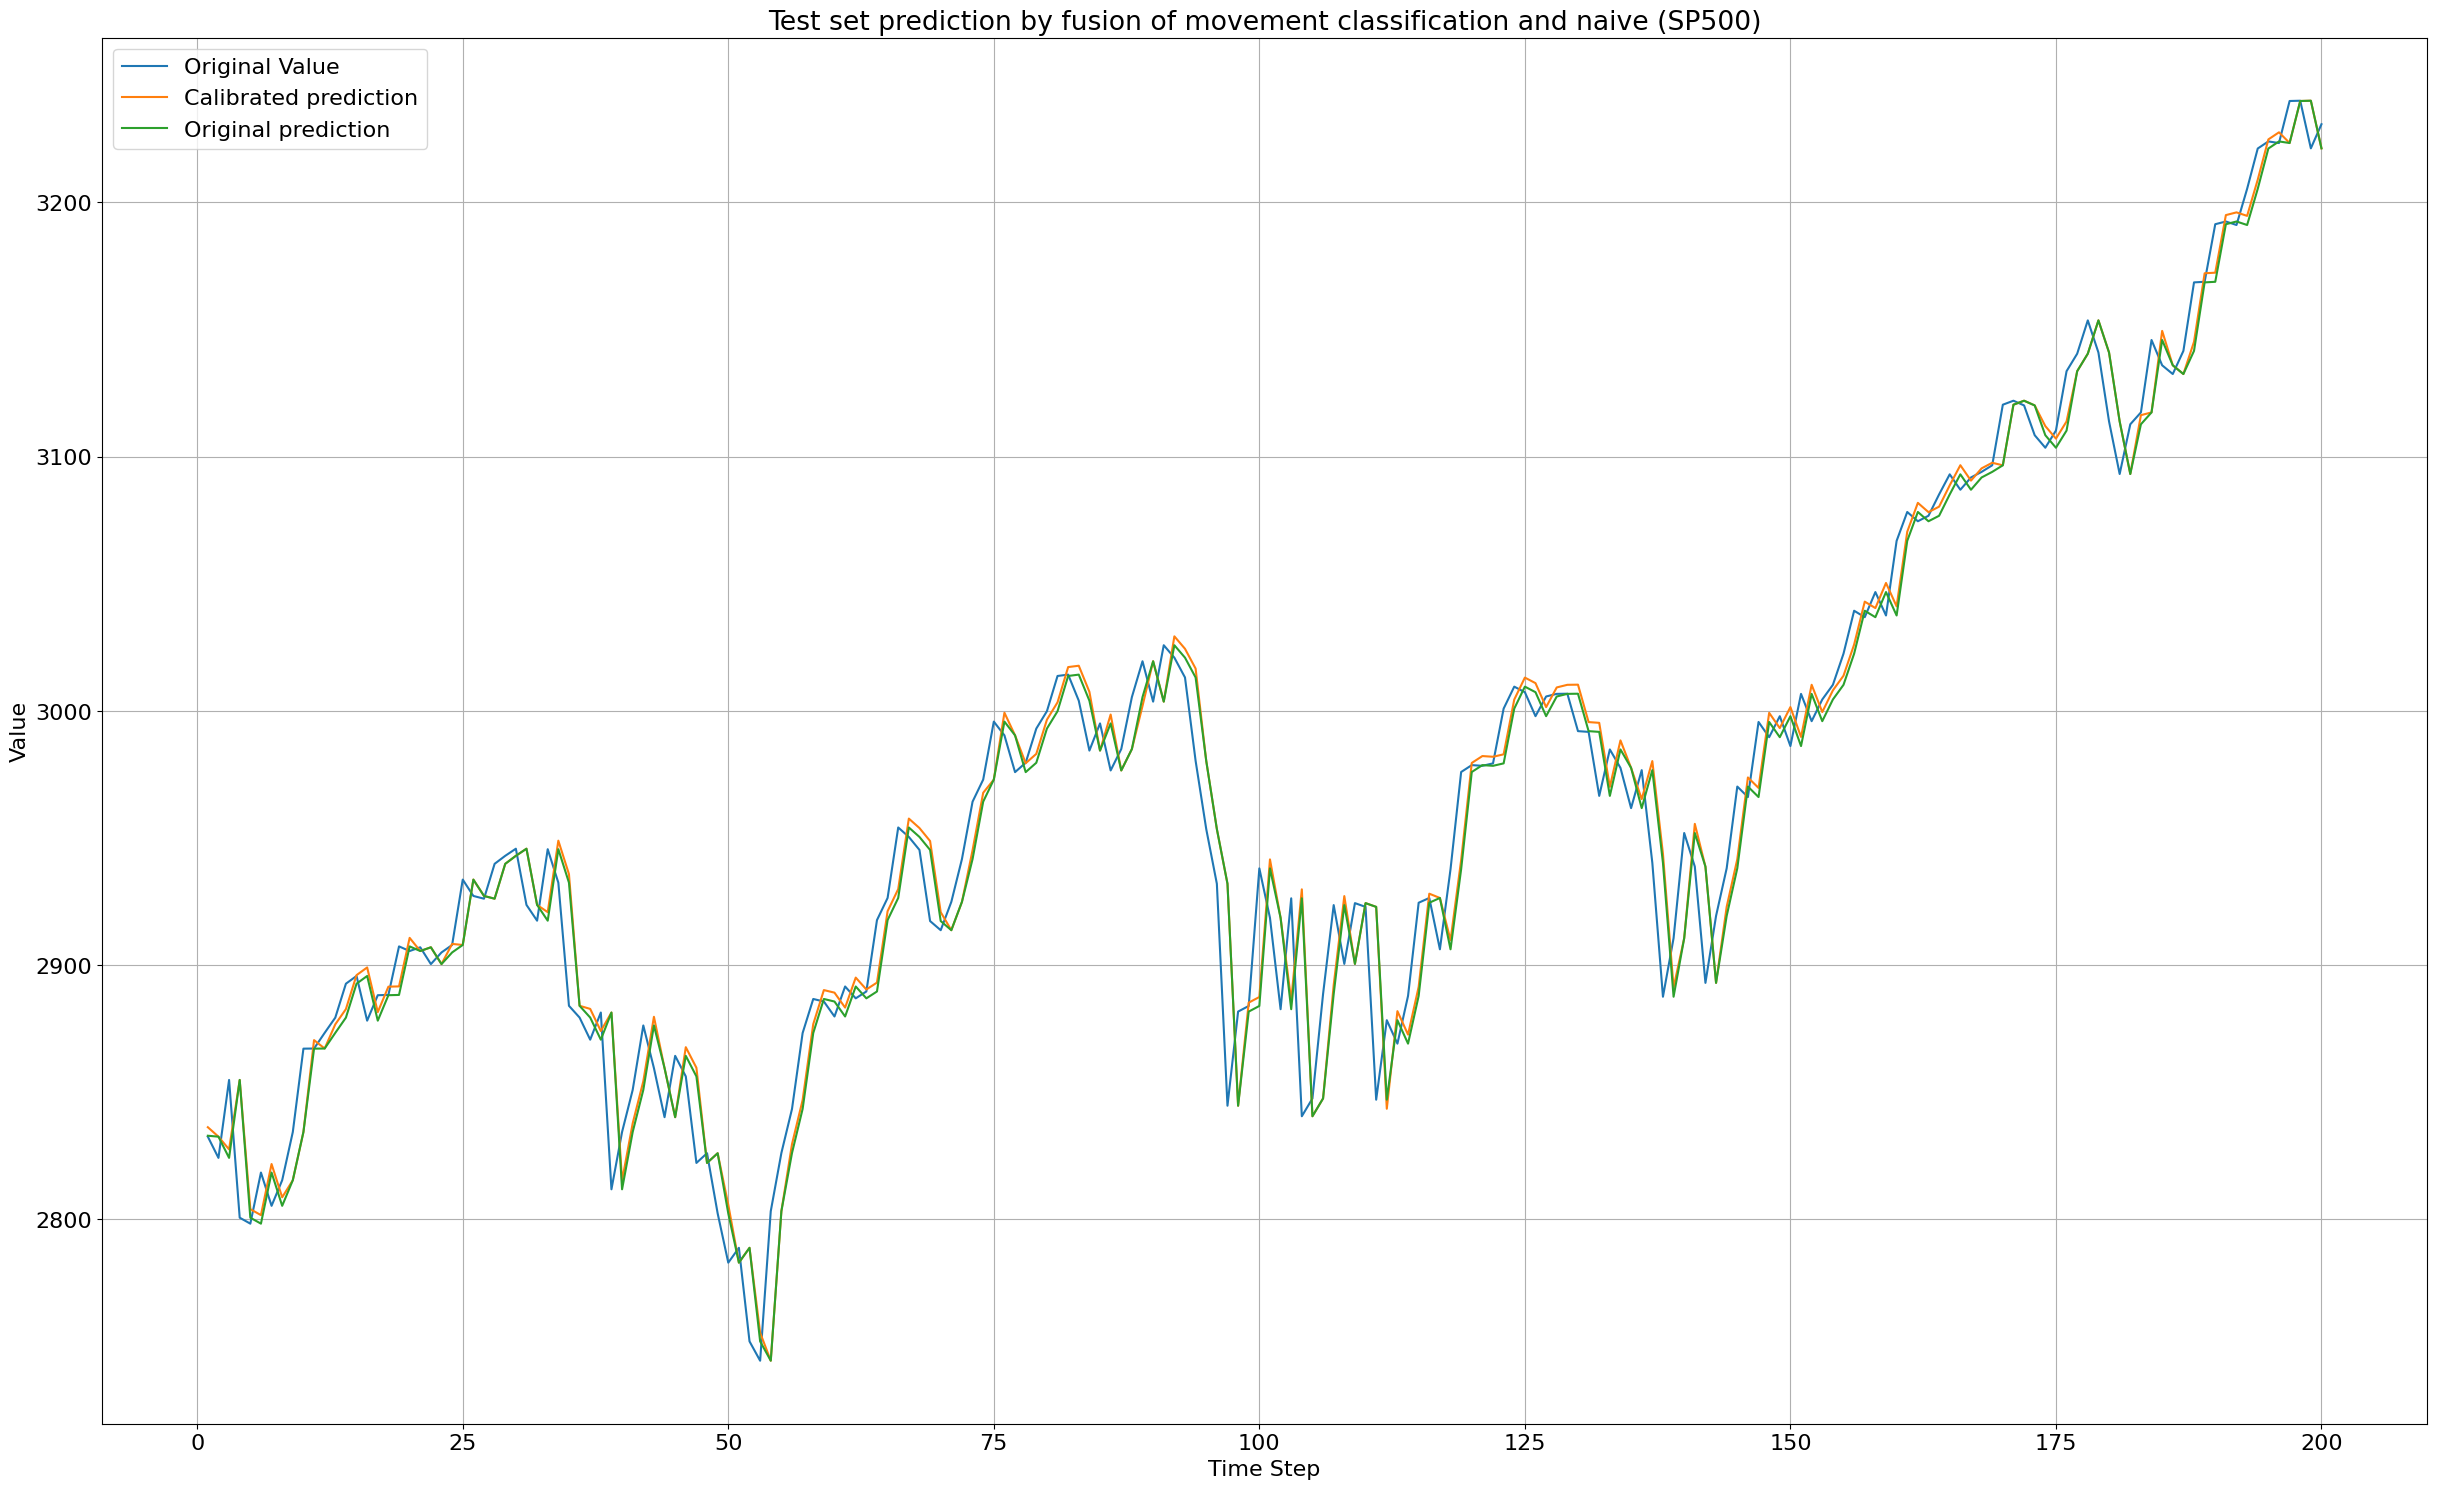

In [55]:
# Plot the calibrated forecast

plt.figure(figsize=(30, 18))
plot_series(np.arange( 1, G.SPLIT_TIME  + 1 ), series_test)
plot_series(np.arange( 1, G.SPLIT_TIME + 1 ), series_test_hat_naive_calibrated)
plot_series(np.arange( 1, G.SPLIT_TIME + 1 ), series_test_hat_naive)
plt.ylabel("Value")
plt.xlabel("Time Step")
plt.title("Test set prediction by fusion of movement classification and naive (SP500)")
legend_drawn_flag = True
plt.legend(["Original Value", "Calibrated prediction", "Original prediction"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Random_walk_prediction/figures/fusion_SP500_exp1.svg")

In [1224]:
np.savetxt("/content/gdrive/MyDrive/Random_walk_prediction/files/test_set_SP500.csv",
           series_test, delimiter=",")

In [1225]:
np.savetxt("/content/gdrive/MyDrive/Random_walk_prediction/files/test_set_prediction_fusion_SP500_exp1.csv",
           series_test_hat_naive_calibrated, delimiter=",")

## Baseline: Point forecasting without fusing binary classification  

### Naive

In [413]:
np.savetxt("/content/gdrive/MyDrive/Random_walk_prediction/files/test_set_prediction_naive_SP500.csv",
           series_test_hat_naive[200:300], delimiter=",")

In [414]:
rmse_test_naive, mae_test_naive, mape_test_naive= compute_metrics(series_test[200:300], series_test_hat_naive[200:300])

In [415]:
print(f"rmse_test_naive: {rmse_test_naive:.4f}, mae_test_naive: {mae_test_naive:.4f} , mape_test_naive: {mape_test_naive:.4f} for forecast")

rmse_test_naive: nan, mae_test_naive: nan , mape_test_naive: nan for forecast


### ARIMA

In [ ]:
from pmdarima import auto_arima

In [ ]:
ARIMA_pred = []

In [ ]:
ARIMA_train = series[-G.SPLIT_TIME-100:-G.SPLIT_TIME]
# ARIMA_train = series[:-G.SPLIT_TIME]
ARIMA_test = series[-G.SPLIT_TIME:]
for i in range(len(series_test)):
    # Fit model on all available data up to the current point
    model = auto_arima(ARIMA_train, stepwise=True, trace=False)

    # Forecast one step ahead
    forecast= model.predict(n_periods=1)

    # Append forecast to the list
    ARIMA_pred.append(forecast)

    # Update training set with the actual value and the forecast
    ARIMA_train = pd.concat([ARIMA_train, ARIMA_test.iloc[i:i+1]])

In [ ]:
ARIMA_pred = np.array(ARIMA_pred)

In [ ]:
ARIMA_pred = np.squeeze(ARIMA_pred)

In [ ]:
rmse_test_ARIMA, mae_test_ARIMA, mape_test_ARIMA= compute_metrics(series_test[200:300], ARIMA_pred[200:300])
print(f"rmse_test_ARIMA: {rmse_test_ARIMA:.4f}, mae_test_ARIMA: {mae_test_ARIMA:.4f} , mape_test_ARIMA: {mape_test_ARIMA:.4f} for forecast")

rmse_test_ARIMA: 22.3094, mae_test_ARIMA: 16.1533 , mape_test_ARIMA: 0.5417 for forecast


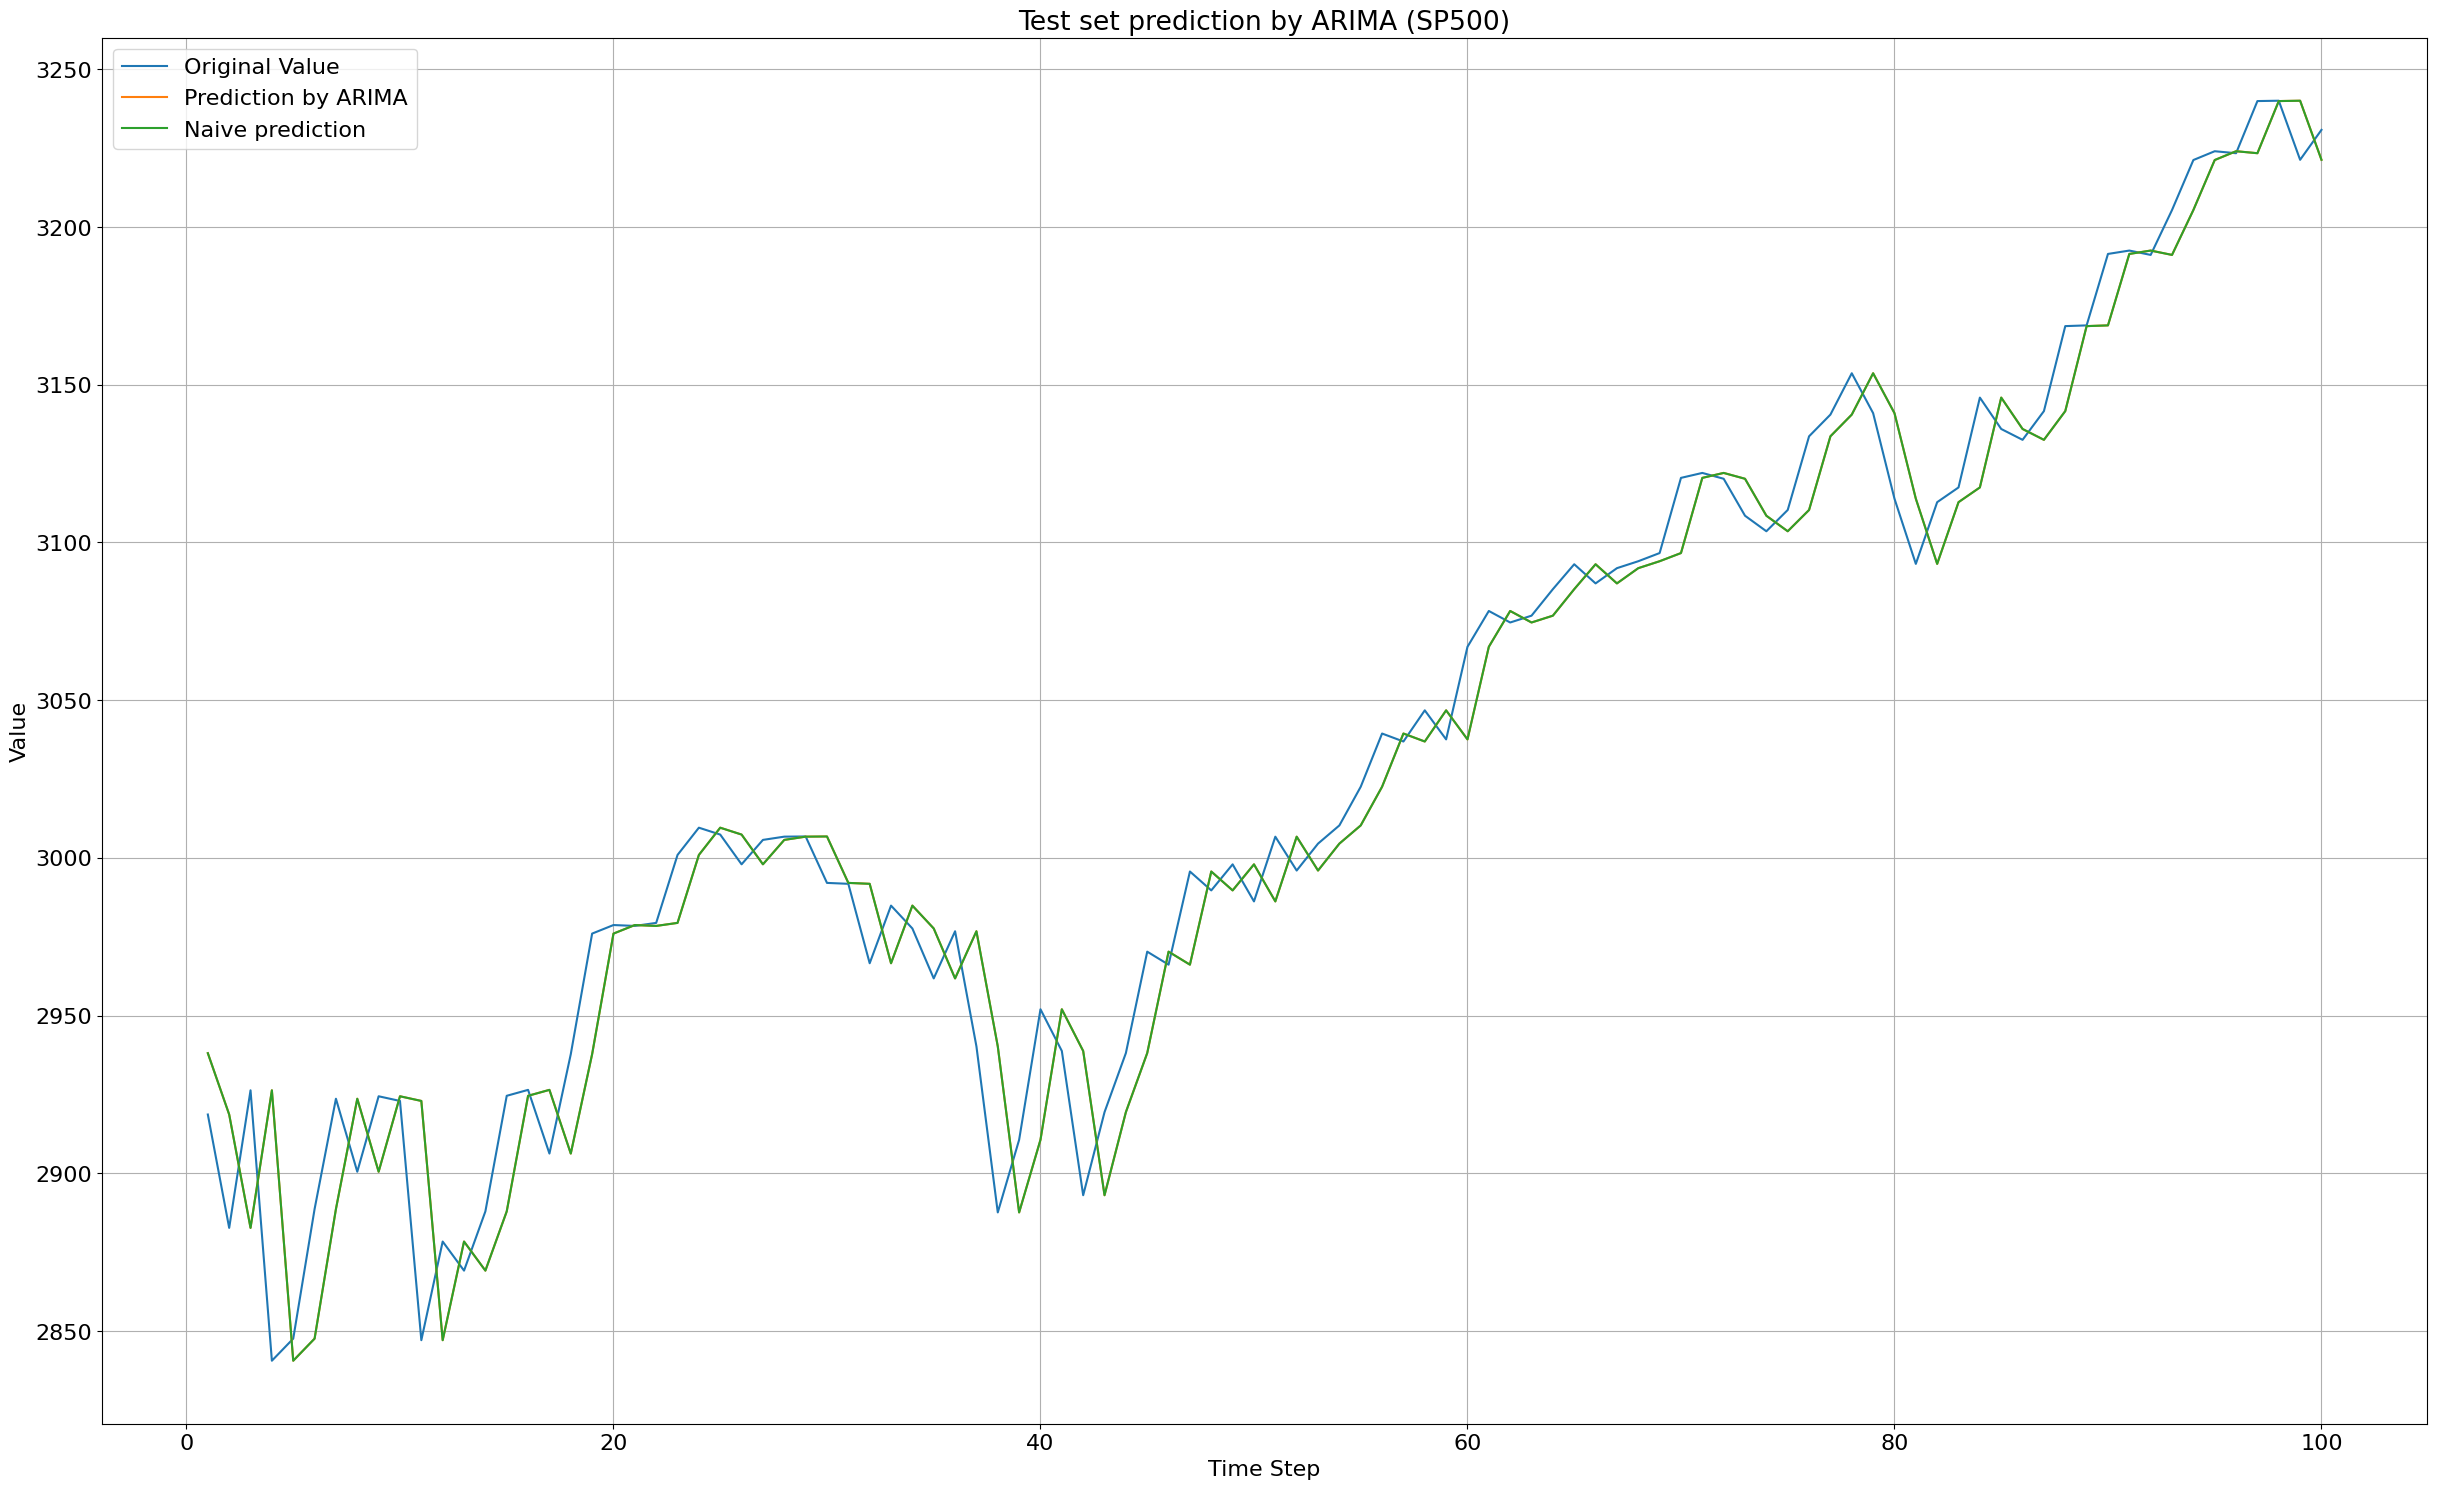

In [ ]:
# Plot the ARIMA forecast

plt.figure(figsize=(30, 18))
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), series_test[200:300])
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), ARIMA_pred[200:300])
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), series_test_hat_naive[200:300])
plt.ylabel("Value")
plt.xlabel("Time Step")
plt.title("Test set prediction by ARIMA (SP500)")
legend_drawn_flag = True
plt.legend(["Original Value", "Prediction by ARIMA", "Naive prediction"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Random_walk_prediction/figures/ARIMA_SP500_exp1.svg")

In [ ]:
np.savetxt("/content/gdrive/MyDrive/Random_walk_prediction/files/test_set_prediction_ARIMA_SP500_exp1.csv",
           ARIMA_pred[200:300], delimiter=",")

### Linear regression

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
y_train_regression = series_train_norm[100+1:]

In [ ]:
series_prediction_list_LR = []

rmse_val_LR = []
mae_val_LR = []
mape_val_LR = []

rmse_test_LR = []
mae_test_LR = []
mape_test_LR = []
coefficient_LR = []

for k in range(32):  ### random optimization. Use a holdout validation set to choose coefficients.

  series_test_hat = []

  coefficient1 = random.uniform(0, 10)
  coefficient_LR.append(coefficient1)

  LR_model = Ridge(alpha=coefficient1)

    # Fit the logistic regression model on the selected features
  LR_model.fit(X_train, y_train_regression)

  LR_pred = LR_model.predict(X_test)
  LR_pred = reverse_normalization(LR_pred)

  series_prediction_list_LR.append(LR_pred)

  rmse_pred_val, mae_pred_val, mape_pred_val= compute_metrics(series_test[0:200], LR_pred[0:200])

  rmse_pred_test, mae_pred_test, mape_pred_test= compute_metrics(series_test[200:300], LR_pred[200:300])

  rmse_val_LR.append(rmse_pred_val)
  mae_val_LR.append(mae_pred_val)
  mape_val_LR.append(mape_pred_val)
  rmse_test_LR.append(rmse_pred_test)
  mae_test_LR.append(mae_pred_test)
  mape_test_LR.append(mape_pred_test)


In [ ]:
min_index_LR =np.argmin(rmse_val_LR)

In [ ]:
best_coefficient_LR = coefficient_LR[min_index_LR]

In [ ]:
best_coefficient_LR

0.14273918096268434

In [ ]:
print(f"rmse_LR_test: {rmse_test_LR[min_index_LR]:.4f}, mae_LR_test: {mae_test_LR[min_index_LR]:.4f} , mape_LR_test: {mape_test_LR[min_index_LR]:.4f} for forecast")

rmse_LR_test: 21.8952, mae_LR_test: 15.7574 , mape_LR_test: 0.5282 for forecast


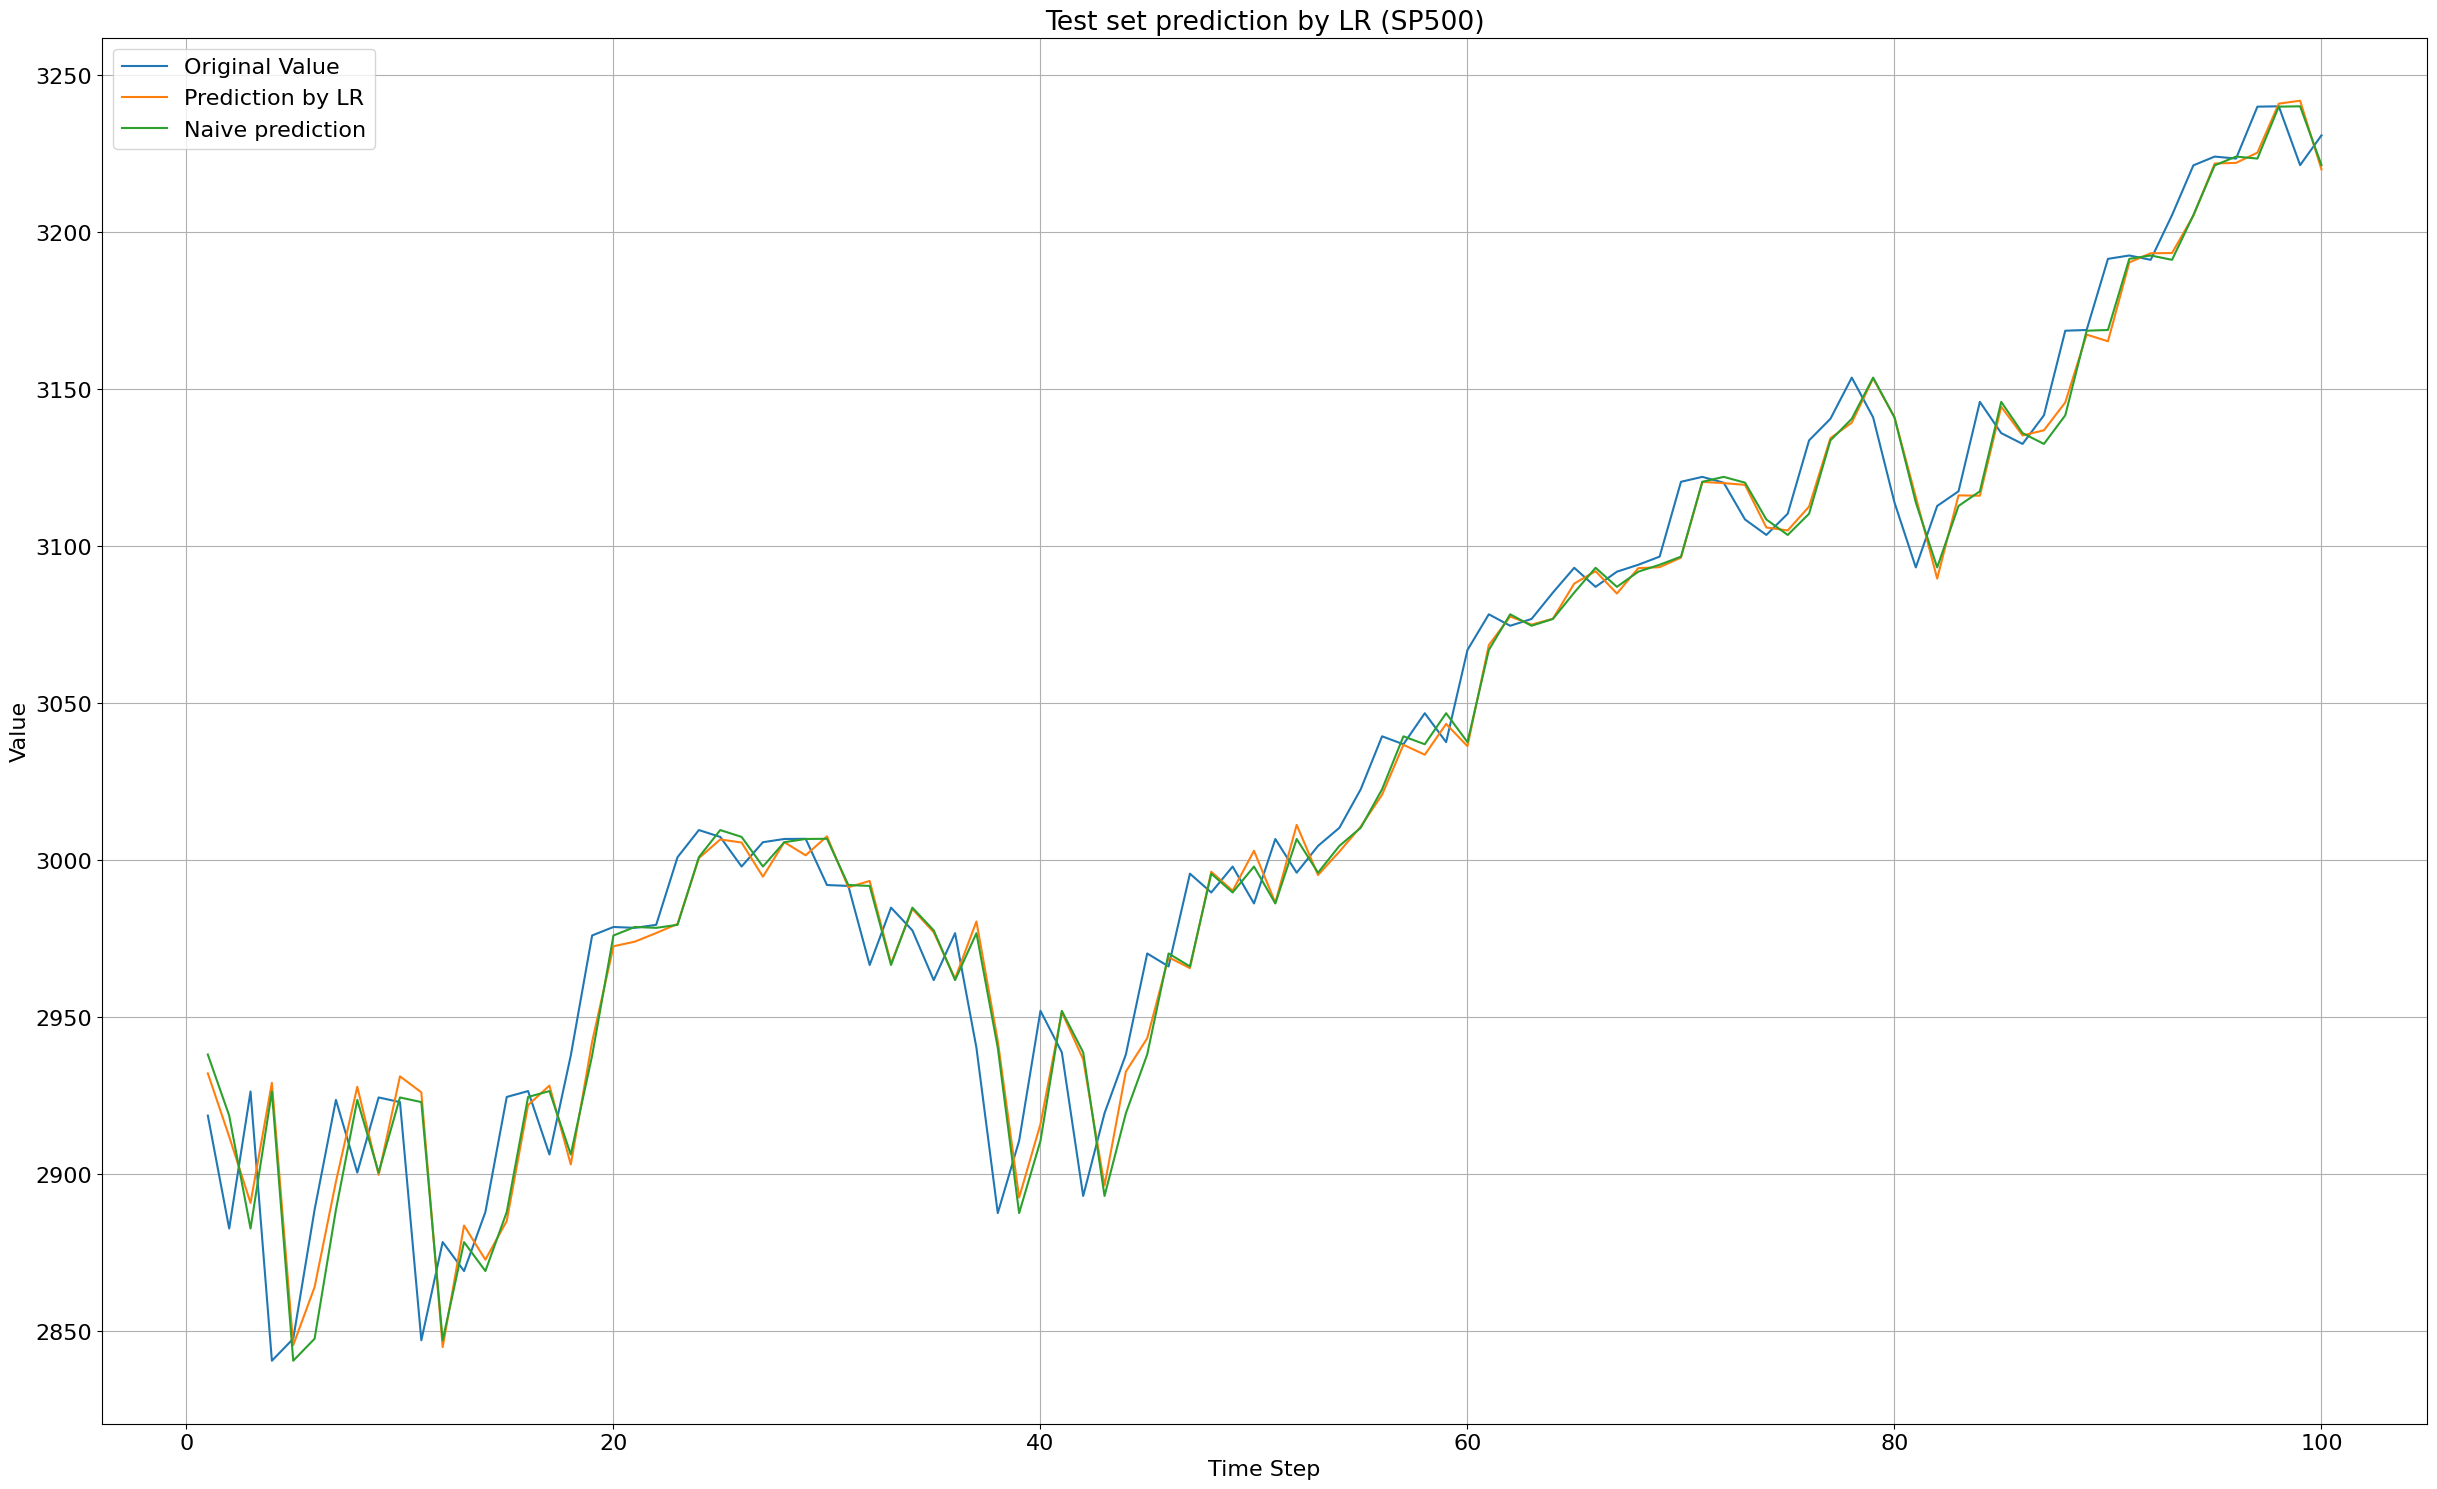

In [ ]:
# Plot the Linear Refression forecast

plt.figure(figsize=(30, 18))
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), series_test[200:300])
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), series_prediction_list_LR[min_index_LR][200:300])
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), series_test_hat_naive[200:300])
plt.ylabel("Value")
plt.xlabel("Time Step")
plt.title("Test set prediction by LR (SP500)")
legend_drawn_flag = True
plt.legend(["Original Value", "Prediction by LR", "Naive prediction"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Random_walk_prediction/figures/LR_SP500_exp1.svg")


In [ ]:
np.savetxt("/content/gdrive/MyDrive/Random_walk_prediction/files/test_set_prediction_LR_SP500_exp1.csv",
           series_prediction_list_LR[min_index_LR][200:300], delimiter=",")

### Multilayer perceptron

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
X_train.shape

(2115, 42)

In [ ]:
series_prediction_list_MLP = []

rmse_val_MLP = []
mae_val_MLP = []
mape_val_MLP = []

rmse_test_MLP = []
mae_test_MLP = []
mape_test_MLP = []
coefficient1_MLP = []
coefficient2_MLP = []
for k in range(32):  ### random optimization. Use a holdout validation set to choose coefficients.

  series_test_hat = []

  coefficient1 = random.randint(1, 100)
  coefficient2 = random.randint(1, 100)
  coefficient1_MLP.append(coefficient1)
  coefficient2_MLP.append(coefficient2)
  # Initialize the MLP model
  MLP_model = Sequential()
  MLP_model.add(Dense(coefficient1, activation='relu', input_dim=X_train.shape[1]))
  MLP_model.add(Dense(coefficient2, activation='relu'))
  MLP_model.add(Dense(1))

  # Compile the model
  MLP_model.compile(optimizer='adam', loss='mean_squared_error')

  # Fit the model
  MLP_model.fit(X_train, y_train_regression, epochs=50, verbose=0)

  # Use the model to make predictions
  MLP_pred = MLP_model.predict(X_test)
  MLP_pred = np.squeeze(MLP_pred)
  MLP_pred = reverse_normalization(MLP_pred)

  series_prediction_list_MLP.append(MLP_pred)

  rmse_pred_val, mae_pred_val, mape_pred_val= compute_metrics(series_test[0:200], MLP_pred[0:200])

  rmse_pred_test, mae_pred_test, mape_pred_test= compute_metrics(series_test[200:300], MLP_pred[200:300])

  rmse_val_MLP.append(rmse_pred_val)
  mae_val_MLP.append(mae_pred_val)
  mape_val_MLP.append(mape_pred_val)
  rmse_test_MLP.append(rmse_pred_test)
  mae_test_MLP.append(mae_pred_test)
  mape_test_MLP.append(mape_pred_test)

10/10 [==============================] - 0s 2ms/step


In [ ]:
min_index_MLP =np.argmin(rmse_val_MLP)

In [ ]:
best_coefficient1_MLP = coefficient1_MLP[min_index_MLP]
best_coefficient2_MLP = coefficient2_MLP[min_index_MLP]

In [ ]:
best_coefficient1_MLP

74

In [ ]:
best_coefficient2_MLP

33

In [ ]:
print(f"rmse_MLP_test: {rmse_test_MLP[min_index_MLP]:.4f}, mae_MLP_test: {mae_test_MLP[min_index_MLP]:.4f} , mape_MLP_test: {mape_test_MLP[min_index_MLP]:.4f} for forecast")

rmse_MLP_test: 26.6061, mae_MLP_test: 19.2682 , mape_MLP_test: 0.6466 for forecast


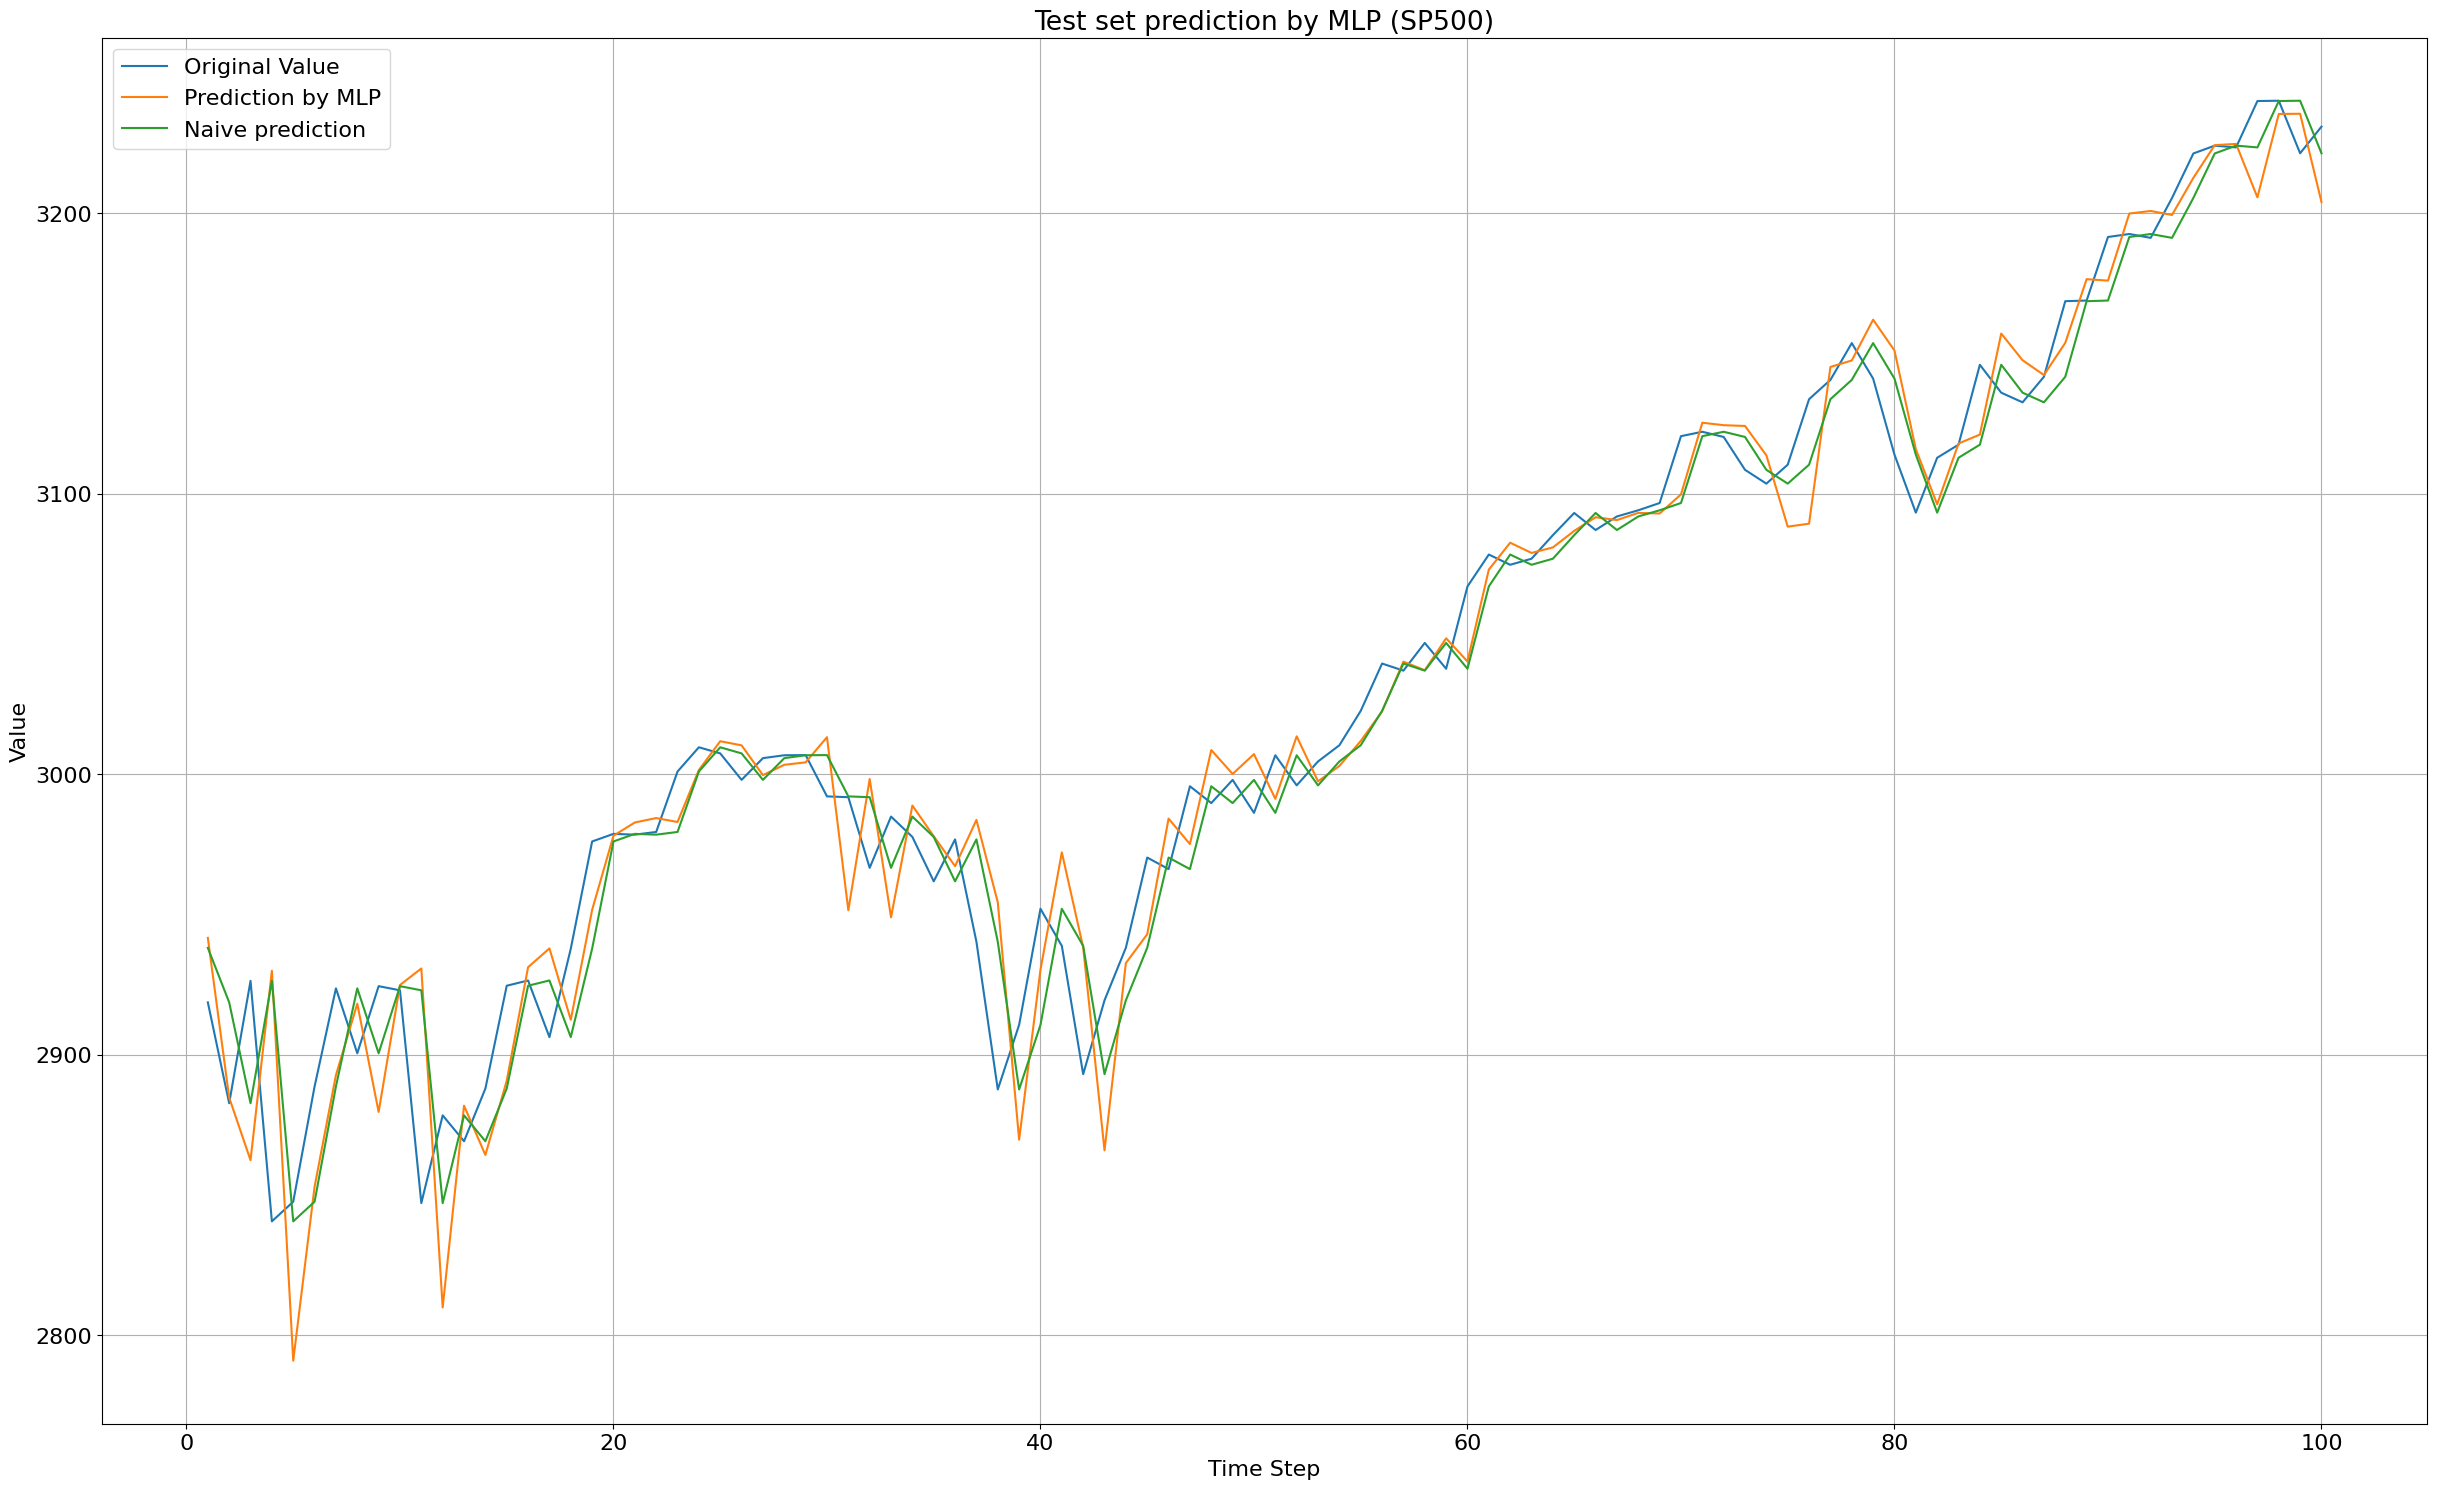

In [ ]:
# Plot the Linear Refression forecast

plt.figure(figsize=(30, 18))
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), series_test[200:300])
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), series_prediction_list_MLP[min_index_MLP][200:300])
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), series_test_hat_naive[200:300])
plt.ylabel("Value")
plt.xlabel("Time Step")
plt.title("Test set prediction by MLP (SP500)")
legend_drawn_flag = True
plt.legend(["Original Value", "Prediction by MLP", "Naive prediction"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Random_walk_prediction/figures/MLP_SP500_exp1.svg")

In [ ]:
np.savetxt("/content/gdrive/MyDrive/Random_walk_prediction/files/test_set_prediction_MLP_SP500_exp1.csv",
           series_prediction_list_MLP[min_index_MLP][200:300], delimiter=",")

### LSTM

In [ ]:
# Create train_set, val_set, and train_val_set. train_set and val_set are used for hyper=parameters tuning, and train_val_set is used for training.
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

train_set = windowed_dataset(series_norm[:-G.SPLIT_TIME], window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE)

In [ ]:
# Prepare callback

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='mae', factor=0.95,patience=5)

In [ ]:
input_shape = (G.WINDOW_SIZE, 1)

In [ ]:
series_prediction_list_LSTM = []

rmse_val_LSTM = []
mae_val_LSTM = []
mape_val_LSTM = []

rmse_test_LSTM = []
mae_test_LSTM = []
mape_test_LSTM = []
coefficient_LSTM = []

for k in range(32):  ### random optimization. Use a holdout validation set to choose coefficients.

  series_test_hat = []

  coefficient1 = random.randint(50, 300)
  coefficient_LSTM.append(coefficient1)
  learning_rates = 0.0005
  # Initialize the LSTM model
  LSTM_model = Sequential()
  LSTM_model.add(tf.keras.layers.LSTM(coefficient1, input_shape=[G.WINDOW_SIZE, 1]))
  LSTM_model.add(Dense(1))

  # Compile the model
  LSTM_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_squared_error',metrics=["mae"])

  # Fit the model
  LSTM_model.fit(train_set, callbacks = [reduce_lr], epochs=200, verbose=0)

  # Use the model to make predictions
  LSTM_pred = model_forecast(LSTM_model, series_norm, G.WINDOW_SIZE).squeeze()

  LSTM_pred = reverse_normalization(LSTM_pred)
  LSTM_pred = LSTM_pred[-G.SPLIT_TIME-1:-1]


  series_prediction_list_LSTM.append(LSTM_pred)

  rmse_pred_val, mae_pred_val, mape_pred_val= compute_metrics(series_test[0:200], LSTM_pred[0:200])

  rmse_pred_test, mae_pred_test, mape_pred_test= compute_metrics(series_test[200:300], LSTM_pred[200:300])

  rmse_val_LSTM.append(rmse_pred_val)
  mae_val_LSTM.append(mae_pred_val)
  mape_val_LSTM.append(mape_pred_val)
  rmse_test_LSTM.append(rmse_pred_test)
  mae_test_LSTM.append(mae_pred_test)
  mape_test_LSTM.append(mape_pred_test)

78/78 [==============================] - 1s 3ms/step


In [ ]:
min_index_LSTM =np.argmin(rmse_val_LSTM)

In [ ]:
best_coefficient_LSTM = coefficient_LSTM[min_index_LSTM]

In [ ]:
best_coefficient_LSTM

63

In [ ]:
print(f"rmse_LSTM_test: {rmse_test_LSTM[min_index_LSTM]:.4f}, mae_LSTM_test: {mae_test_LSTM[min_index_LSTM]:.4f} , mape_LSTM_test: {mape_test_LSTM[min_index_LSTM]:.4f} for forecast")

rmse_LSTM_test: 22.9903, mae_LSTM_test: 17.4553 , mape_LSTM_test: 0.5824 for forecast


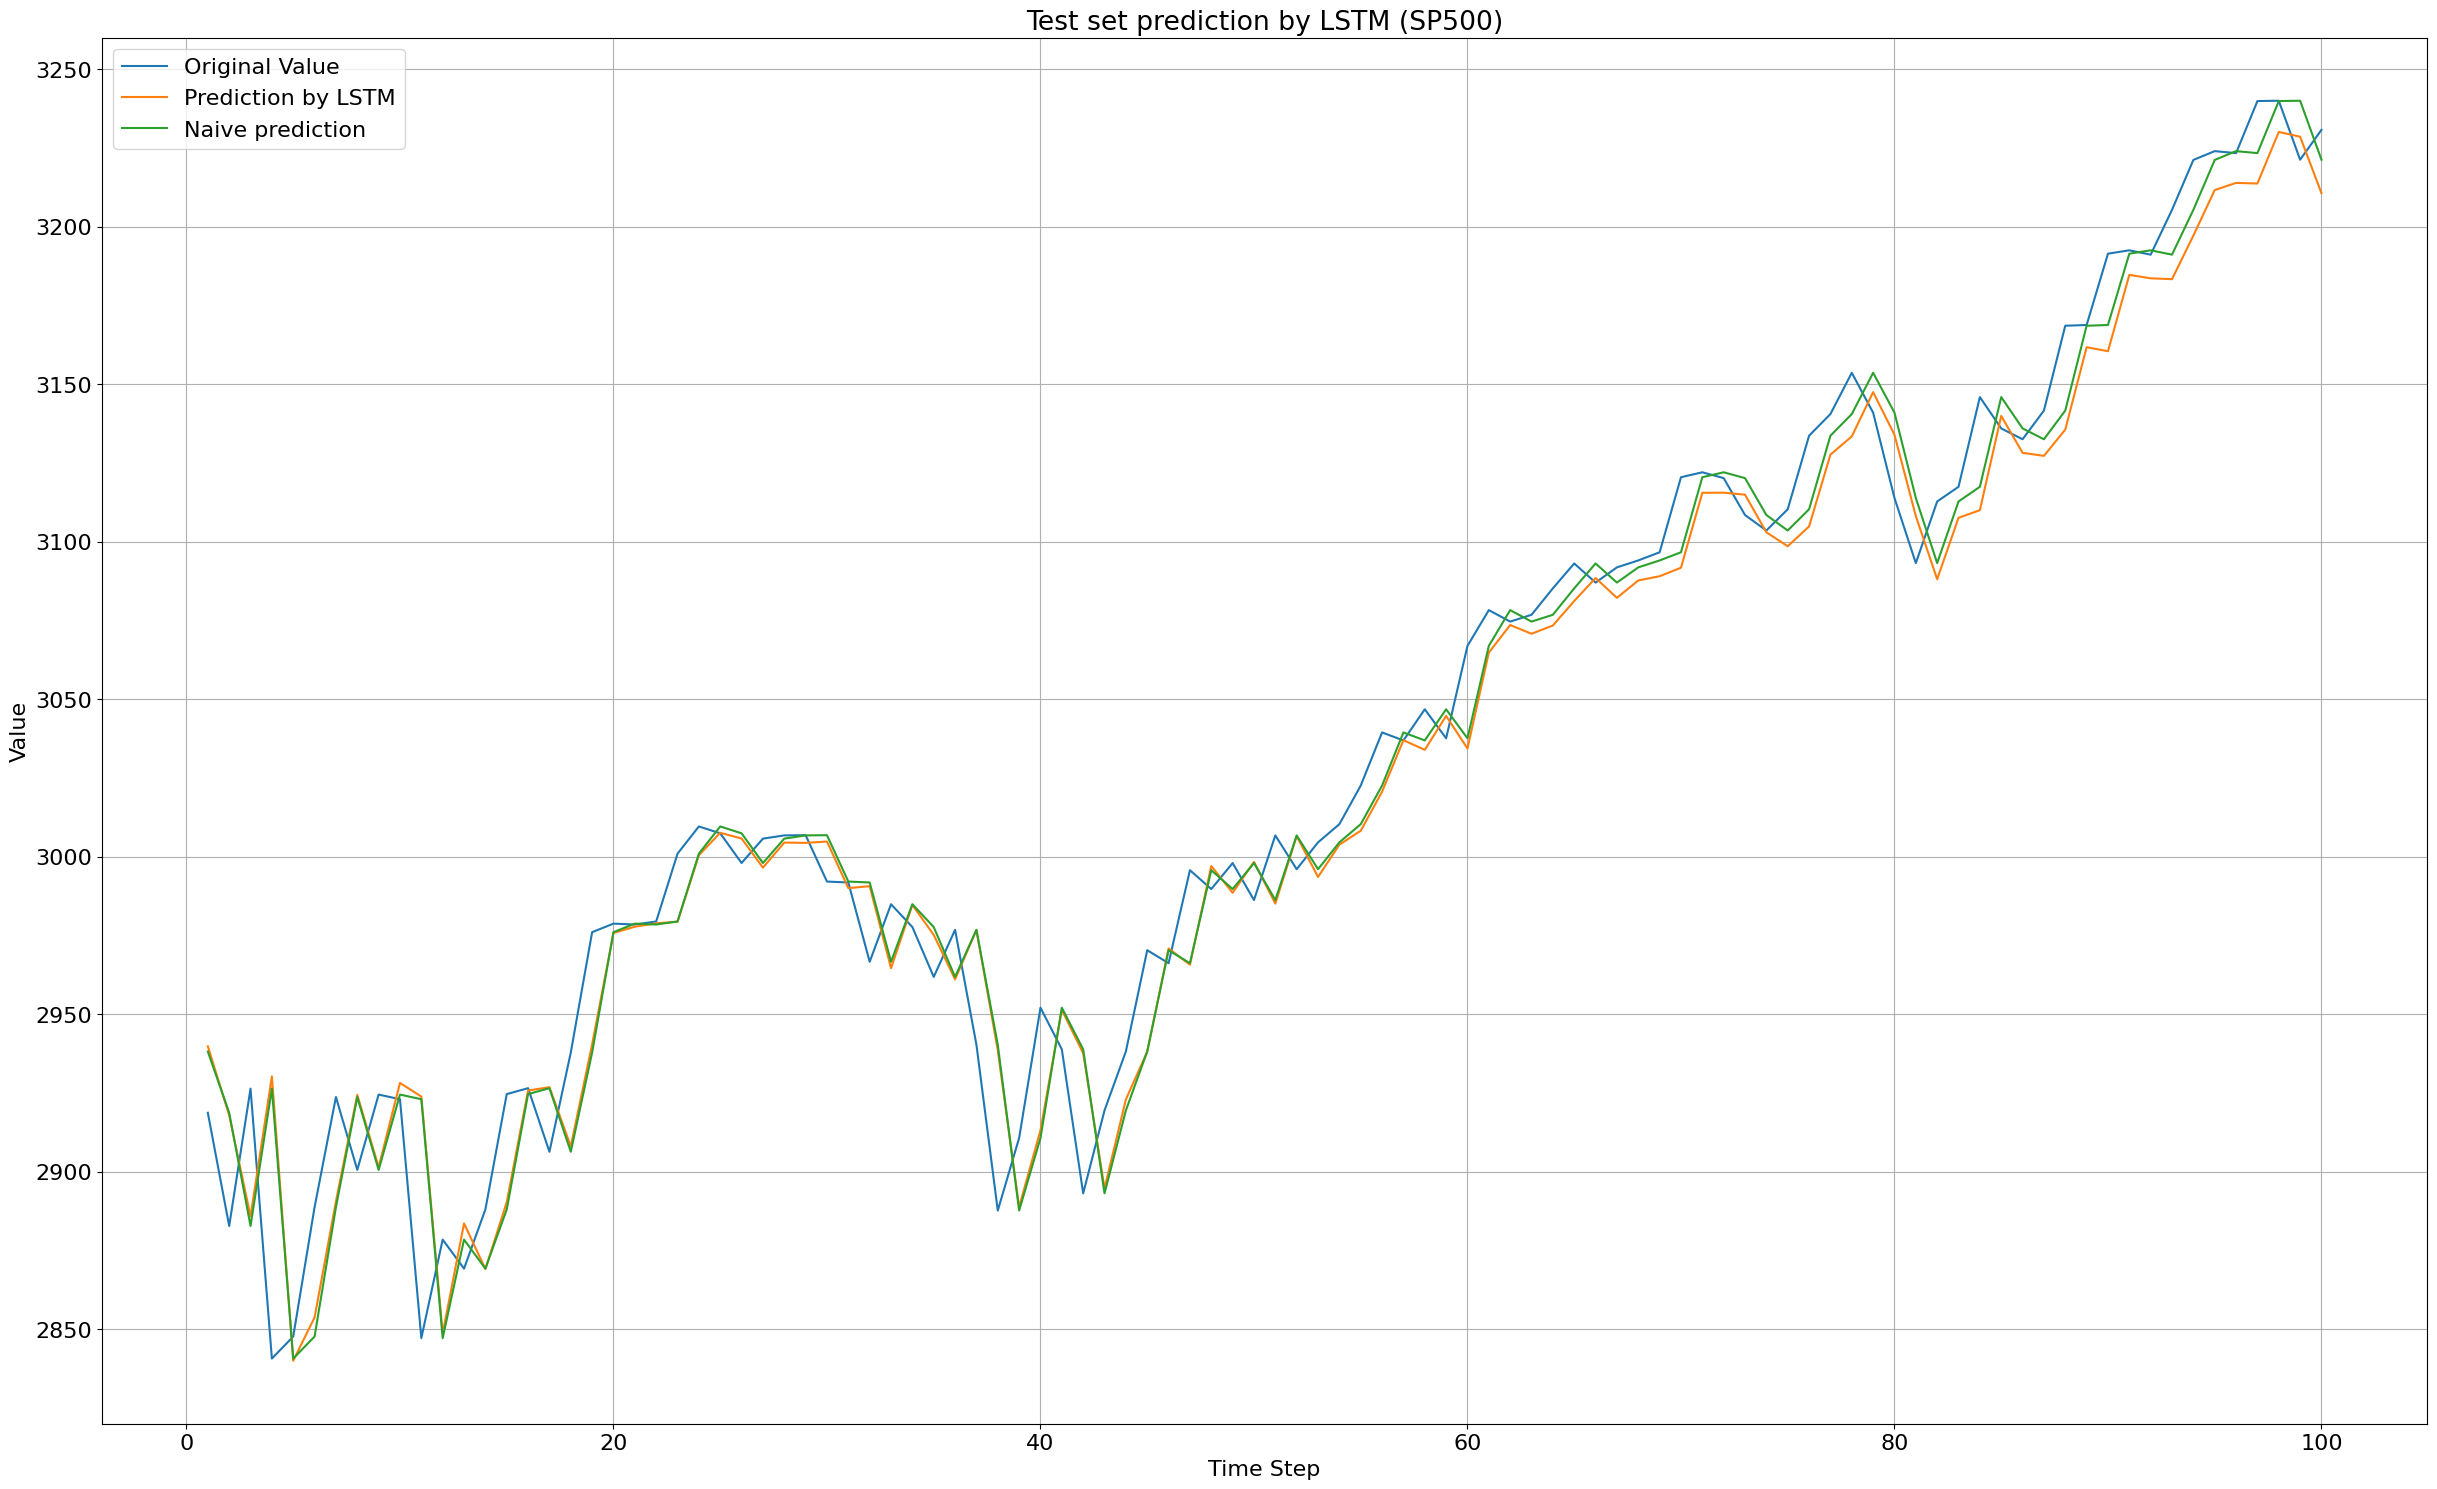

In [ ]:
# Plot the LSTM forecast

plt.figure(figsize=(30, 18))
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), series_test[200:300])
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), series_prediction_list_LSTM[min_index_LSTM][200:300])
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), series_test_hat_naive[200:300])
plt.ylabel("Value")
plt.xlabel("Time Step")
plt.title("Test set prediction by LSTM (SP500)")
legend_drawn_flag = True
plt.legend(["Original Value", "Prediction by LSTM", "Naive prediction"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Random_walk_prediction/figures/LSTM_SP500_exp1.svg")

In [ ]:
np.savetxt("/content/gdrive/MyDrive/Random_walk_prediction/files/test_set_prediction_LSTM_SP500_exp1.csv",
           series_prediction_list_LSTM[min_index_LSTM][200:300], delimiter=",")

### CNN-LSTM

In [ ]:
series_prediction_list_CNN_LSTM = []

rmse_val_CNN_LSTM = []
mae_val_CNN_LSTM = []
mape_val_CNN_LSTM = []

rmse_test_CNN_LSTM = []
mae_test_CNN_LSTM = []
mape_test_CNN_LSTM = []
coefficient1_CNN_LSTM = []
coefficient2_CNN_LSTM = []
for k in range(32):  ### random optimization. Use a holdout validation set to choose coefficients.

  series_test_hat = []

  coefficient1 = random.randint(50, 300)
  coefficient2 = random.randint(50, 300)
  coefficient1_CNN_LSTM.append(coefficient1)
  coefficient2_CNN_LSTM.append(coefficient2)

  learning_rates = 0.0005
  # Initialize the CNN_LSTM model
  CNN_LSTM_model = Sequential()

  CNN_LSTM_model.add(tf.keras.layers.Conv1D(filters=coefficient1, kernel_size=2,
                                 strides=1,
                                 activation="relu",
                                 padding='causal',
                                 input_shape=[G.WINDOW_SIZE, 1]))
  CNN_LSTM_model.add(tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="same"))
  CNN_LSTM_model.add(tf.keras.layers.LSTM(coefficient2, input_shape=[G.WINDOW_SIZE, 1]))
  CNN_LSTM_model.add(Dense(1))

  # Compile the model
  CNN_LSTM_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mean_squared_error',metrics=["mae"])

  # Fit the model
  CNN_LSTM_model.fit(train_set, callbacks = [reduce_lr], epochs=200, verbose=0)

  # Use the model to make predictions
  CNN_LSTM_pred = model_forecast(CNN_LSTM_model, series_norm, G.WINDOW_SIZE).squeeze()

  CNN_LSTM_pred = reverse_normalization(CNN_LSTM_pred)
  CNN_LSTM_pred = CNN_LSTM_pred[-G.SPLIT_TIME-1:-1]


  series_prediction_list_CNN_LSTM.append(CNN_LSTM_pred)

  rmse_pred_val, mae_pred_val, mape_pred_val= compute_metrics(series_test[0:200], CNN_LSTM_pred[0:200])

  rmse_pred_test, mae_pred_test, mape_pred_test= compute_metrics(series_test[200:300], CNN_LSTM_pred[200:300])

  rmse_val_CNN_LSTM.append(rmse_pred_val)
  mae_val_CNN_LSTM.append(mae_pred_val)
  mape_val_CNN_LSTM.append(mape_pred_val)
  rmse_test_CNN_LSTM.append(rmse_pred_test)
  mae_test_CNN_LSTM.append(mae_pred_test)
  mape_test_CNN_LSTM.append(mape_pred_test)

78/78 [==============================] - 1s 4ms/step


In [ ]:
min_index_CNN_LSTM =np.argmin(rmse_val_CNN_LSTM)

In [ ]:
best_coefficient1_CNN_LSTM = coefficient1_CNN_LSTM[min_index_CNN_LSTM]
best_coefficient2_CNN_LSTM = coefficient2_CNN_LSTM[min_index_CNN_LSTM]

In [ ]:
best_coefficient1_CNN_LSTM

294

In [ ]:
best_coefficient2_CNN_LSTM

63

In [ ]:
print(f"rmse_CNN_LSTM_test: {rmse_test_CNN_LSTM[min_index_CNN_LSTM]:.4f}, mae_CNN_LSTM_test: {mae_test_CNN_LSTM[min_index_CNN_LSTM]:.4f} , mape_CNN_LSTM_test: {mape_test_CNN_LSTM[min_index_CNN_LSTM]:.4f} for forecast")

rmse_CNN_LSTM_test: 25.8974, mae_CNN_LSTM_test: 20.7811 , mape_CNN_LSTM_test: 0.6882 for forecast


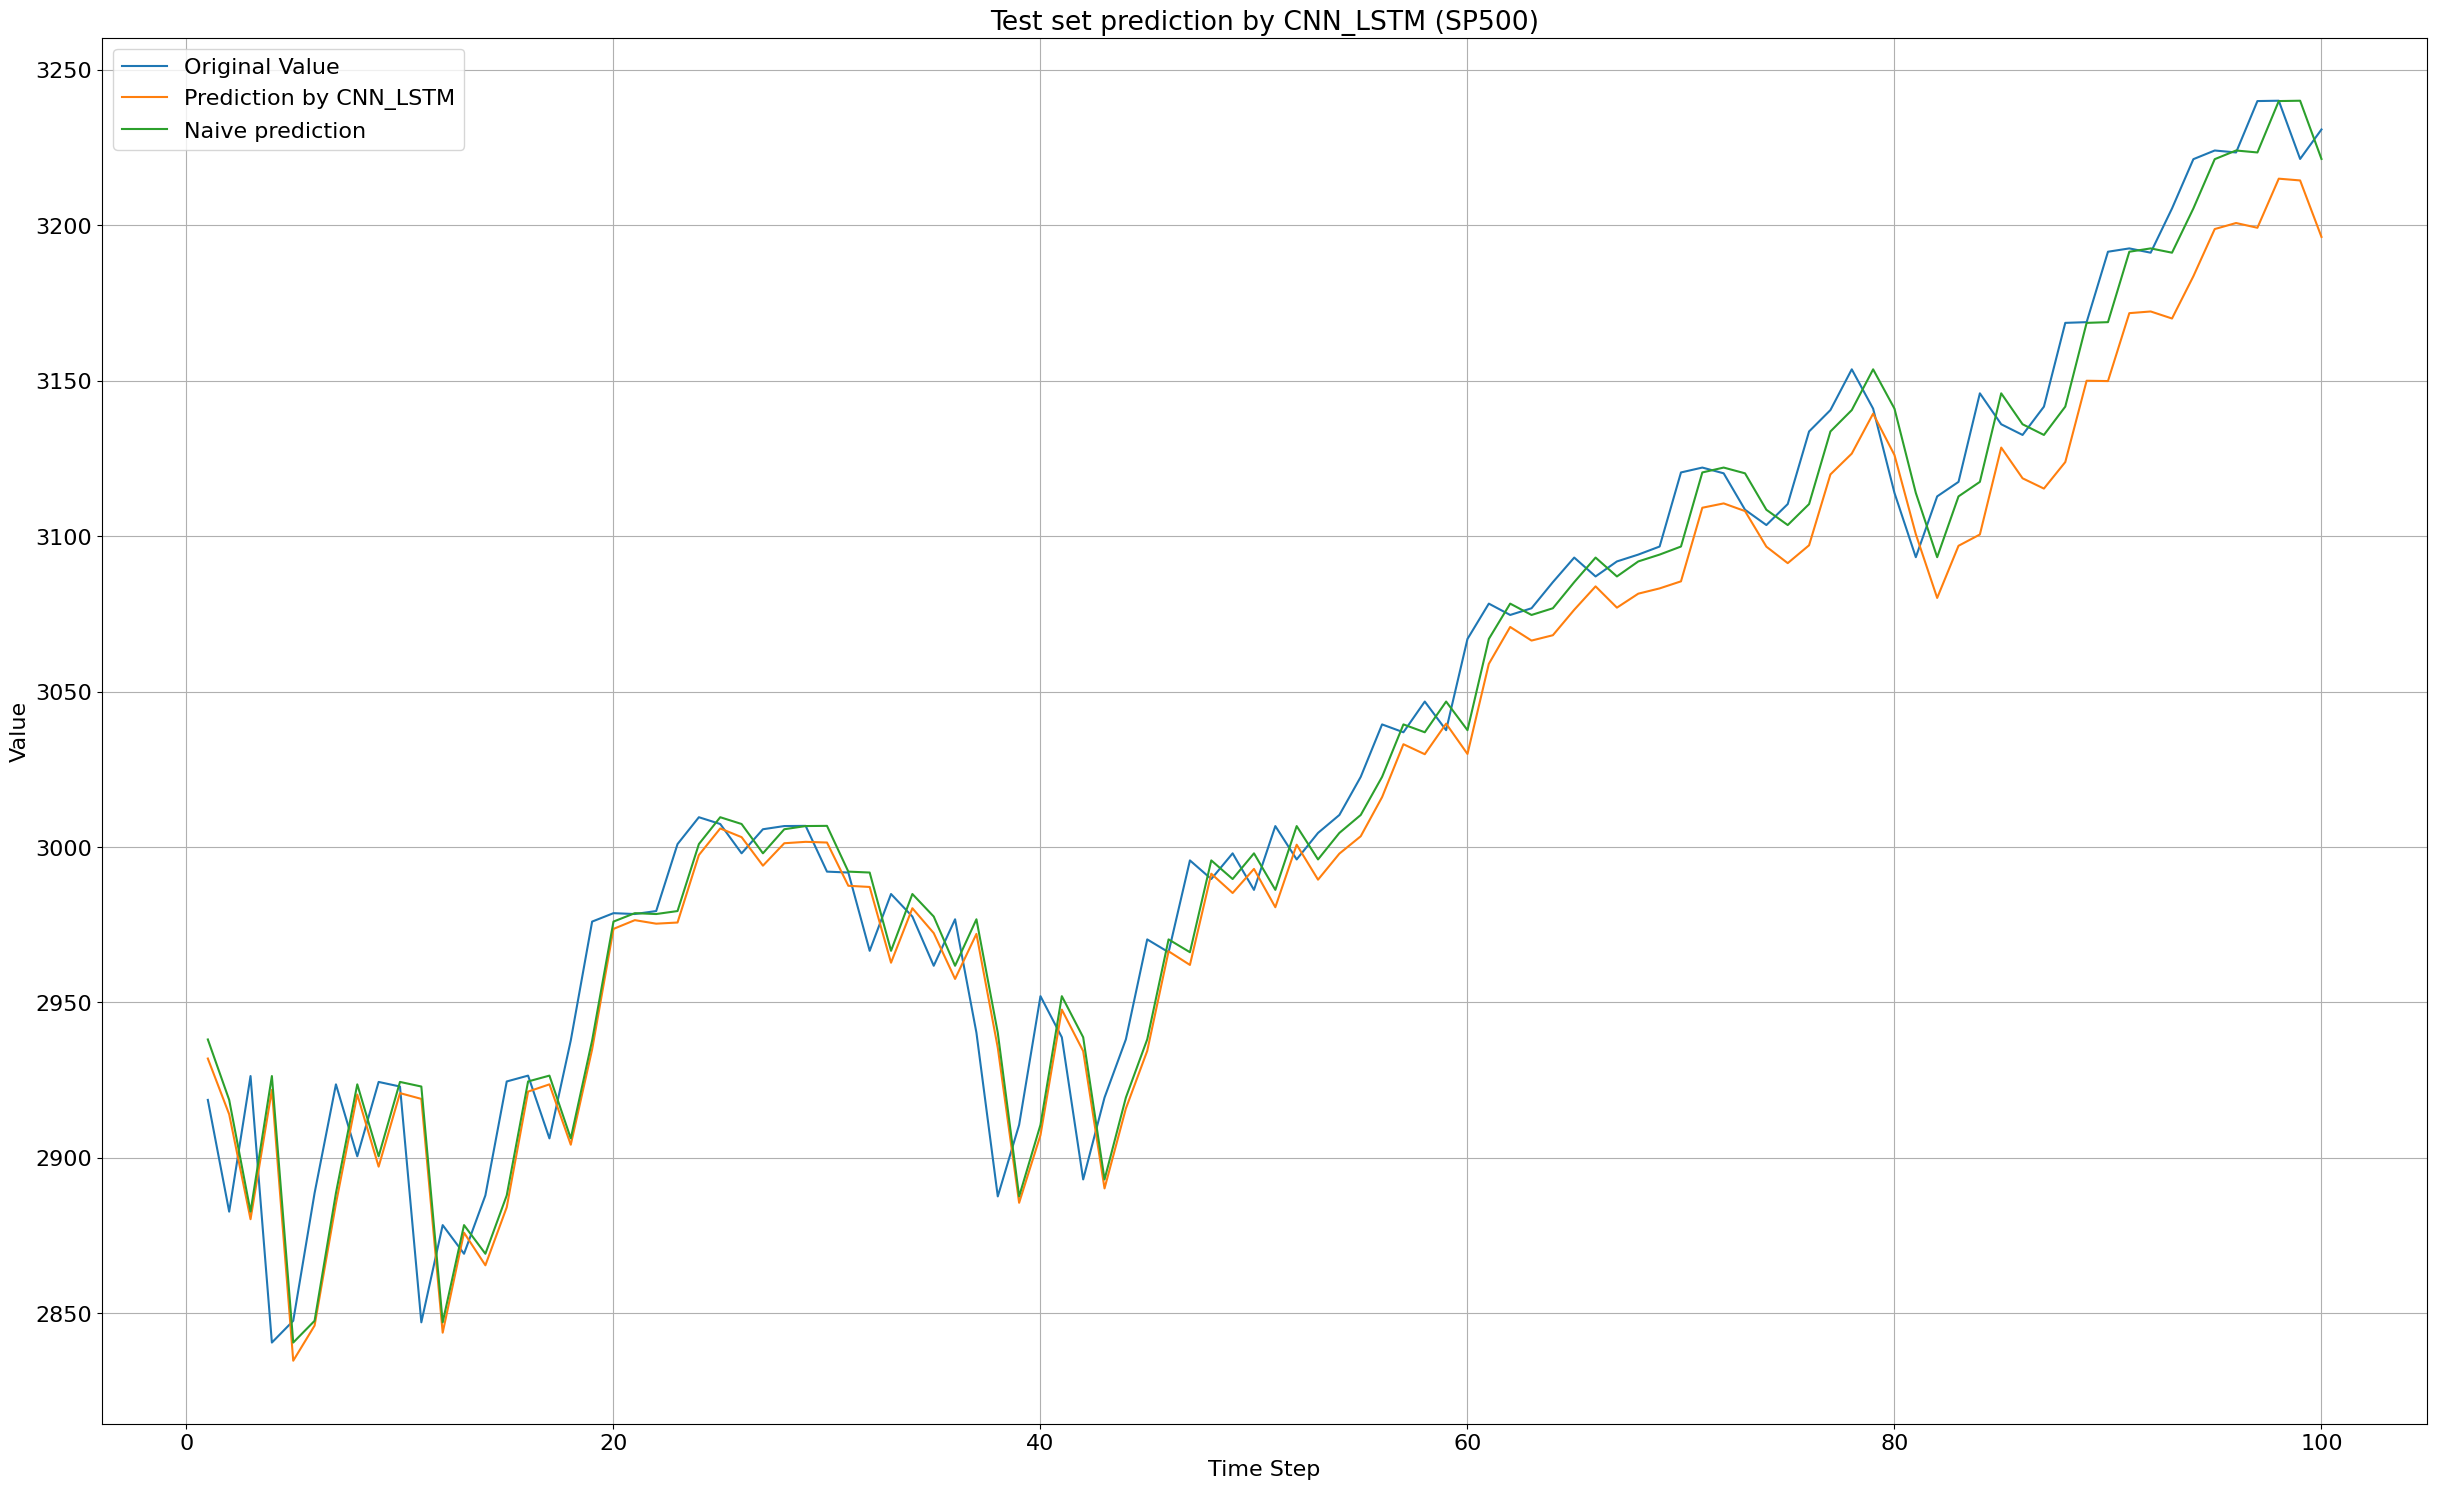

In [ ]:
# Plot the CNN-LSTM forecast

plt.figure(figsize=(30, 18))
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), series_test[200:300])
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), series_prediction_list_CNN_LSTM[min_index_CNN_LSTM][200:300])
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), series_test_hat_naive[200:300])
plt.ylabel("Value")
plt.xlabel("Time Step")
plt.title("Test set prediction by CNN_LSTM (SP500)")
legend_drawn_flag = True
plt.legend(["Original Value", "Prediction by CNN_LSTM", "Naive prediction"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Random_walk_prediction/figures/CNN_LSTM_SP500_exp1.svg")

In [ ]:
np.savetxt("/content/gdrive/MyDrive/Random_walk_prediction/files/test_set_prediction_CNN_LSTM_SP500_exp1.csv",
           series_prediction_list_CNN_LSTM[min_index_CNN_LSTM][200:300], delimiter=",")

## Comparison of model performance

### Plot all predictions together

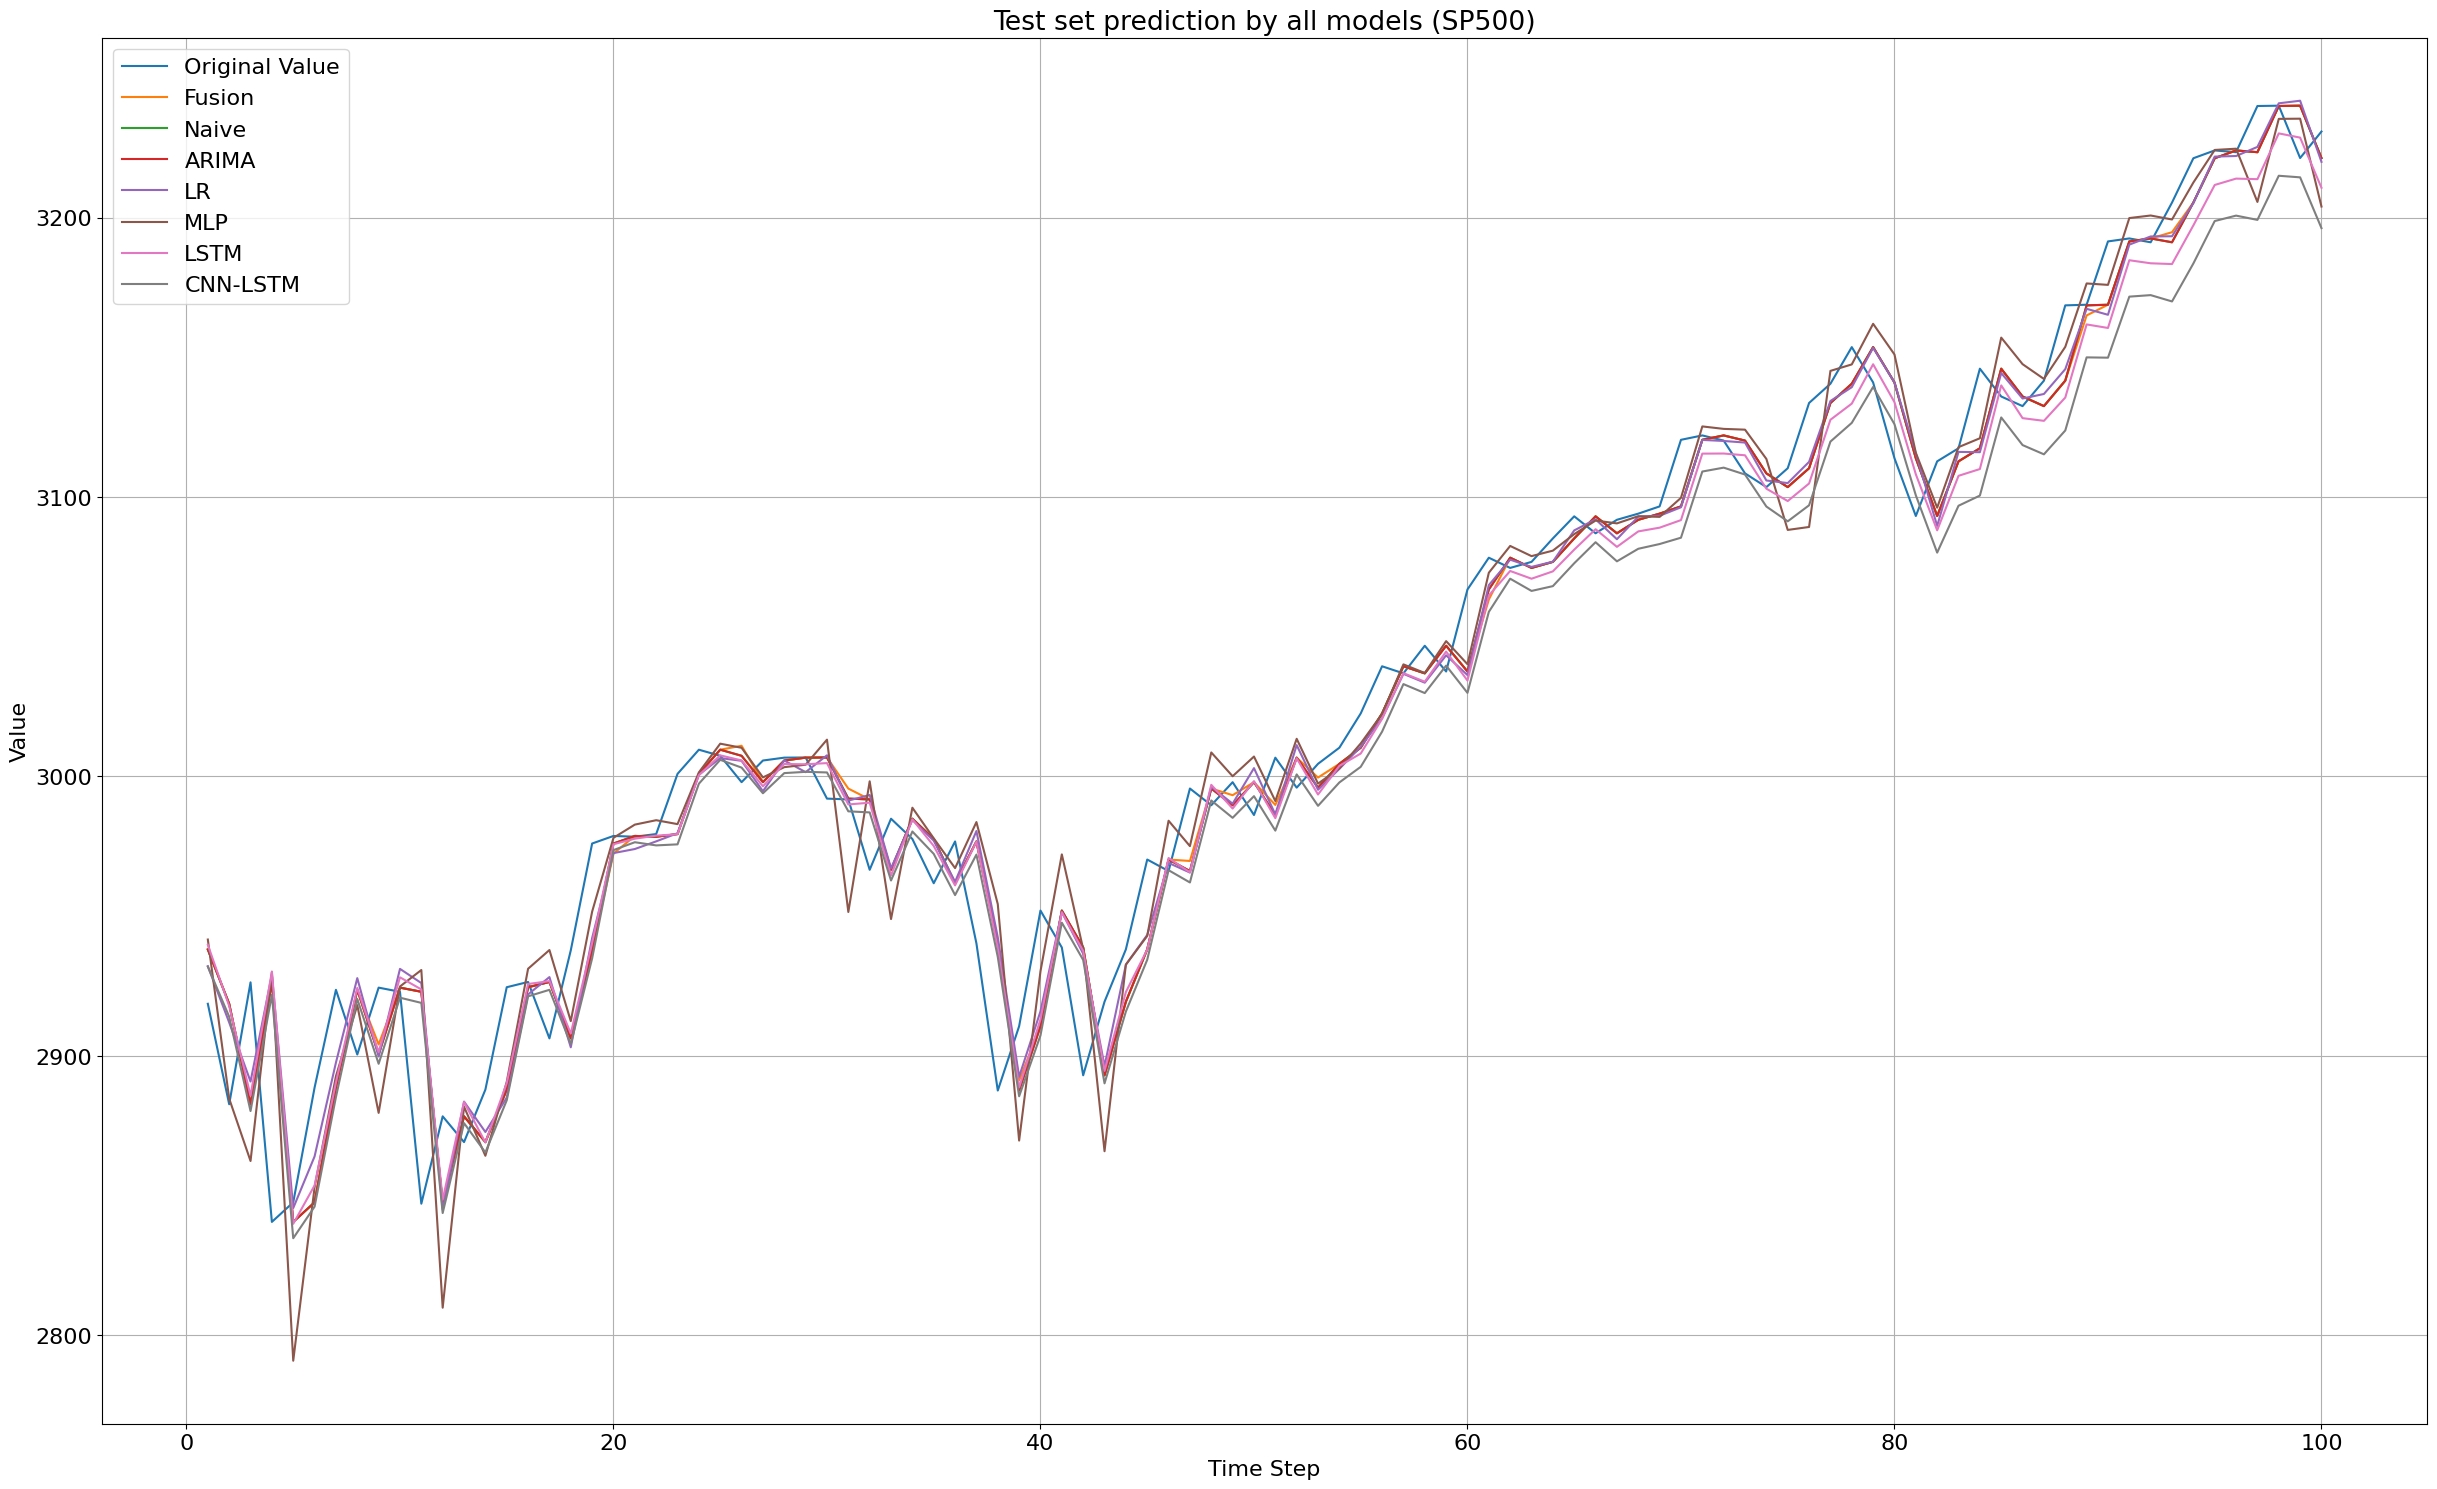

In [ ]:
# Plot the CNN-LSTM forecast

plt.figure(figsize=(30, 18))
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), series_test[200:300])
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), series_test_hat_naive_calibrated[200:300])
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), series_test_hat_naive[200:300])
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), ARIMA_pred[200:300])
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), series_prediction_list_LR[min_index_LR][200:300])
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), series_prediction_list_MLP[min_index_MLP][200:300])
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), series_prediction_list_LSTM[min_index_LSTM][200:300])
plot_series(np.arange( 1, G.SPLIT_TIME //3 + 1 ), series_prediction_list_CNN_LSTM[min_index_CNN_LSTM][200:300])

plt.ylabel("Value")
plt.xlabel("Time Step")
plt.title("Test set prediction by all models (SP500)")
legend_drawn_flag = True
plt.legend(["Original Value", "Fusion", "Naive", "ARIMA","LR","MLP","LSTM","CNN-LSTM"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Random_walk_prediction/figures/ALL_MODELS_SP500_exp1.svg")

### Evaluation metrics comparison

In [ ]:
# Create a dictionary where keys are column names and values are your variables
data = {'Models':['Fusion','naive','ARIMA','LR', 'MLP', 'LSTM', 'CNN_LSTM'],\
        'RMSE': [rmse_test_fusion, rmse_test_naive, rmse_test_ARIMA, rmse_test_LR[min_index_LR], rmse_test_MLP[min_index_MLP], rmse_test_LSTM[min_index_LSTM], rmse_test_CNN_LSTM[min_index_CNN_LSTM]],\
        'MAE': [mae_test_fusion, mae_test_naive, mae_test_ARIMA, mae_test_LR[min_index_LR], mae_test_MLP[min_index_MLP], mae_test_LSTM[min_index_LSTM], mae_test_CNN_LSTM[min_index_CNN_LSTM]],\
        'MAPE': [mape_test_fusion, mape_test_naive, mape_test_ARIMA, mape_test_LR[min_index_LR], mape_test_MLP[min_index_MLP], mape_test_LSTM[min_index_LSTM], mape_test_CNN_LSTM[min_index_CNN_LSTM]]}

# Create DataFrame
df = pd.DataFrame(data)

print(df)

     Models       RMSE        MAE      MAPE
0    Fusion  22.175891  16.080827  0.539181
1     naive  22.309418  16.153300  0.541668
2     ARIMA  22.309418  16.153300  0.541668
3        LR  21.895155  15.757427  0.528190
4       MLP  26.606062  19.268242  0.646627
5      LSTM  22.990326  17.455299  0.582438
6  CNN_LSTM  25.897448  20.781057  0.688215
